In [29]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np

import torch
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
from optimizers import PSPS

import matplotlib.pyplot as plt

from datasets import get_dataset    
from loss_fns import get_loss
from utils import solve

from loss_functions import mse, grad_mse, hess_mse

torch.set_default_dtype(torch.float64)

from sklearn.datasets import load_svmlight_file

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [30]:
device = torch.device('cpu')

In [31]:
# Multiplies a matrix M by a vector v per row 
# i_th row of a matrix M is multiplied by a i_th number of a vector v 
# returns a matrix with the same size as M 
def mxvec_row_mul(M, v):
    return M * v[:, None]

def rademacher_old(weights):
    return torch.round(torch.rand_like(weights)) * 2 - 1

def diag_estimate_old(weights, grad, iters):
    Ds = []
    for j in range(iters):
        z = rademacher_old(weights)
        with torch.no_grad():
            hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
        Ds.append((hvp*z))

    return torch.mean(torch.stack(Ds), 0)


def hess_diag_approx(weights, grad, iters):
    Ds = torch.zeros_like(weights)
    for j in range(iters):
        z = rademacher_old(weights)
        with torch.no_grad():
            hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
        Ds.add_(hvp*z)
    return Ds.div(iters)

def citardouq_solve(a, b, c):
    det = b * b - 4 * a * c
    if det < 1e-40:
        x1 = 0.0
        x2 = 0.0
    else:
        x1 = (2 * c) / (-b - np.sqrt(det))
        x2 = (2 * c) / (-b + np.sqrt(det))
    return np.asarray([x1, x2])

In [32]:
def get_synthetic(mode, n, d, scale, seed=0):
    
    np.random.seed(seed)
    A_rand = np.random.randn(n,d)
    U, S, VH = np.linalg.svd(A_rand)
    if mode != "none":
        S *= 0.0
        eigs = [1/((x+1)**2) for x in range(S.shape[0])]
        if mode == "easy":
            S = np.asarray(eigs)
        elif mode == "hard":
            S = np.concatenate(([10.0, 5.0], eigs[:-2]))
    
    A = np.dot(U[:, :S.shape[0]] * S, VH)

    xopt = np.random.randn(d)
    b = A @ xopt 
    train_data = torch.Tensor(A)
    train_target = torch.Tensor(b)
    xopt = torch.Tensor(xopt)

    # scaling 
    # if scale == 0 then nothing changes and scaling_vec is ones
    r1 = -scale
    r2 = scale
    scaling_vec = (r1 - r2) * torch.rand(train_data.shape[1]) + r2
    scaling_vec = torch.pow(torch.e, scaling_vec)
    train_data = scaling_vec * train_data
    return train_data, train_target, scaling_vec, xopt, S

In [7]:
train_data, train_target, _, xopt, S = get_synthetic("none", 100, 100, 0, 0)
train_data_scaled, train_target_scaled, scaling_vec, xopt_scaled, S_scaled = get_synthetic("none", 100, 100, 5, 0)

# train_load = torch.utils.data.TensorDataset(train_data, train_target)
# train_dataloader = torch.utils.data.DataLoader(train_load, batch_size=batch_size, shuffle=True)

In [34]:
n = 100
d = 20

A = np.random.randn(n, d)
U, S, VH = np.linalg.svd(A)
L_max = np.max(S)
# A = A.T @ A # make it symmetric and positive definite

assert np.linalg.matrix_rank(A) == d

xopt = np.random.randn(d)
b = A @ xopt

train_data = torch.Tensor(A)
train_target = torch.Tensor(b)
xopt = torch.Tensor(xopt)

EPOCHS = 100
batch_size = 100

train_load = torch.utils.data.TensorDataset(train_data, train_target)
train_dataloader = torch.utils.data.DataLoader(train_load, batch_size=batch_size, shuffle=True)


scale = 5
r1 = -scale
r2 = scale
scaling_vec = (r1 - r2) * torch.rand(train_data.shape[1]) + r2
scaling_vec = torch.pow(torch.e, scaling_vec)
train_data_scaled = scaling_vec * train_data

train_load_scaled = torch.utils.data.TensorDataset(train_data_scaled, train_target)
train_dataloader_scaled = torch.utils.data.DataLoader(train_load_scaled, batch_size=batch_size, shuffle=True)

In [35]:
func = mse 
grad = grad_mse 
hess = hess_mse

In [10]:
def sgd(train_data, train_target, train_dataloader, lr):
    w = torch.zeros(train_data.shape[1])
    loss = func(w, train_data, train_target)
    g = grad(w, train_data, train_target)
    
    hist = [[loss.item(), torch.sum(torch.square(g)).item()]]

    for epoch in range(EPOCHS):

        for batch_data, batch_target in train_dataloader:

            loss = func(w, batch_data, batch_target)
            g = grad(w, batch_data, batch_target)

            with torch.no_grad():
                w.sub_(lr * g)
        
        loss = func(w, train_data, train_target)
        g = grad(w, train_data, train_target)

        hist.append([loss.item(), torch.sum(torch.square(g)).item()])

    return hist

In [11]:
def sps(train_data, train_target, train_dataloader, precond_method="none", init_hutch=10000):
    w = torch.zeros(train_data.shape[1]).requires_grad_()

    loss = func(w, train_data, train_target)
    # g = grad(w, train_data, train_target)
    g = torch.autograd.grad(loss, w, create_graph=True)[0]

    if precond_method == "none":
        precond = torch.ones(A.shape[1])
    elif precond_method == "hessdiag":
        hessian = hess(train_data)
        hessian_diag = torch.diag(hessian)
        precond = 1 / hessian_diag
    elif precond_method == "scaling_vec":
        precond = (1 / scaling_vec)**2
    elif precond_method == "hutch":
        hessian = hess(train_data)
        hessian_diag = torch.diag(hessian)
        D = hess_diag_approx(w, g, init_hutch)
        beta = 0.999
        alpha = 0.01
        # D = torch.relu(D)
        D_inv = 1 / D
        precond = D_inv

    hist = [[loss.item(), torch.sum(torch.square(g)).item()]]
        
    for epoch in range(EPOCHS):

        for batch_data, batch_target in train_dataloader:

            loss = func(w, batch_data, batch_target)
            g = torch.autograd.grad(loss, w, create_graph=True)[0]

            if precond_method == "hutch":
                v = hess_diag_approx(w, g, 1)
                D = beta * D + (1 - beta) * v
                D = torch.abs(D)
                D[D < alpha] = alpha    
                # D = torch.relu(D)
                D_inv =  1 / D
                precond = D_inv
                # print(f"norm(hessian_diag - D): { torch.norm(hessian_diag - D) }")

            weighted_grad_norm =  torch.dot(g, precond * g)

            ps = loss / weighted_grad_norm

            with torch.no_grad():
                w.sub_(ps * precond * g)
        
        loss = func(w, train_data, train_target)
        g = grad(w, train_data, train_target)

        hist.append([loss.item(), torch.sum(torch.square(g)).item()])

    return hist

In [12]:
def nm(train_data, train_target, train_dataloader):
    w = torch.zeros(train_data.shape[1])

    loss = func(w, train_data, train_target)
    g = grad(w, train_data, train_target)
    
    hist = [[loss.item(), torch.sum(torch.square(g)).item()]]

    hessian = hess(train_data)
    hessian_inv = torch.inverse(hessian)
        

    for epoch in range(EPOCHS):

        for batch_data, batch_target in train_dataloader:

            loss = func(w, batch_data, batch_target)
            g = grad(w, batch_data, batch_target)

            with torch.no_grad():
                w.sub_(hessian_inv @ g)

        loss = func(w, train_data, train_target)
        g = grad(w, train_data, train_target)
        hist.append([loss.item(), torch.sum(torch.square(g)).item()])

    return hist

In [13]:
def ps_adagrad(train_data, train_target, train_dataloader, sqrt_=True):
    w = torch.zeros(train_data.shape[1])

    loss = func(w, train_data, train_target)
    g = grad(w, train_data, train_target)
    
    hist = [[loss.item(), torch.sum(torch.square(g)).item()]]

    precond = torch.zeros_like(g)

    op = lambda x: torch.sqrt(x) if sqrt_ else x 
    for epoch in range(EPOCHS):

        for batch_data, batch_target in train_dataloader:

            loss = func(w, batch_data, batch_target)
            g = grad(w, batch_data, batch_target)
            precond.add_(torch.square(g))
            precond_inv = 1 / (op(precond) + 1e-10) 
            weighted_grad_norm =  torch.dot(g, precond_inv * g)
            ps = loss / weighted_grad_norm

            with torch.no_grad():
                w.sub_(ps * precond_inv * g)
        
        loss = func(w, train_data, train_target)
        g = grad(w, train_data, train_target)

        hist.append([loss.item(), torch.sum(torch.square(g)).item()])

    return hist

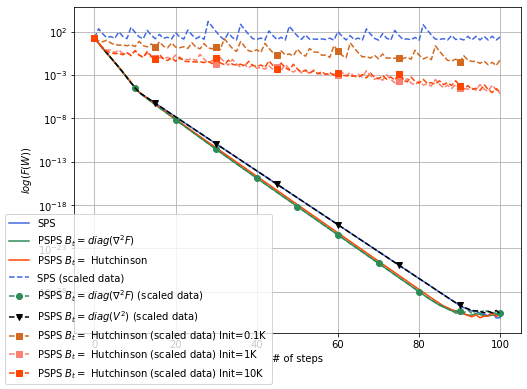

In [14]:
fig = plt.figure(figsize=(8, 6))

h = sps(train_data, train_target, train_dataloader, "none")
plt.semilogy([x[0] for x in h], color="royalblue", label="SPS")
# ax2.semilogy([x[1] for x in h])

h = sps(train_data, train_target, train_dataloader, "hessdiag")
plt.semilogy([x[0] for x in h], color="seagreen", label=r"PSPS $ B_t = diag(\nabla^2 F) $")
# ax2.semilogy([x[1] for x in h])

h = sps(train_data, train_target, train_dataloader, "hutch", 10000)
plt.semilogy([x[0] for x in h], color="orangered", label=r"PSPS $ B_t =$ Hutchinson ")
# ax2.semilogy([x[1] for x in h])

# for i in [1/L_max, 1e-1, 1e-3]:
#     h = sgd(train_data, train_target, train_dataloader, i)
#     plt.semilogy([x[0] for x in h], label=f"sgd: {i}")
#     ax2.semilogy([x[1] for x in h])

h = sps(train_data_scaled, train_target, train_dataloader_scaled, "none")
plt.semilogy([x[0] for x in h], color="royalblue", linestyle="--", label="SPS (scaled data)")
# ax2.semilogy([x[1] for x in h], linestyle="--")

h = sps(train_data_scaled, train_target, train_dataloader_scaled, "hessdiag")
markevery = [x for x in range(0, len(h), 10)]  
plt.semilogy([x[0] for x in h], color="seagreen", linestyle="--", marker="o", markevery=markevery, label=r"PSPS $ B_t = diag(\nabla^2 F) $ (scaled data)")
# ax2.semilogy([x[1] for x in h], color="k", linestyle="--", marker="o", markevery=markevery)

h = sps(train_data_scaled, train_target, train_dataloader_scaled, "scaling_vec")
markevery = [x for x in range(0, len(h), 15)]  
plt.semilogy([x[0] for x in h], color="k", linestyle="--", marker="v", markevery=markevery, label=r"PSPS $B_t = diag(V^2)$ (scaled data)")
# ax2.semilogy([x[1] for x in h], linestyle="--", marker="v", markevery=markevery)

h = sps(train_data_scaled, train_target, train_dataloader_scaled, "hutch", 100)
markevery = [x for x in range(0, len(h), 15)]  
plt.semilogy([x[0] for x in h], color="chocolate", linestyle="--", marker="s", markevery=markevery, label=r"PSPS $ B_t =$ Hutchinson (scaled data) Init=0.1K")


h = sps(train_data_scaled, train_target, train_dataloader_scaled, "hutch", 1000)
markevery = [x for x in range(0, len(h), 15)]  
plt.semilogy([x[0] for x in h], color="salmon", linestyle="--", marker="s", markevery=markevery, label=r"PSPS $ B_t =$ Hutchinson (scaled data) Init=1K")


h = sps(train_data_scaled, train_target, train_dataloader_scaled, "hutch", 10000)
markevery = [x for x in range(0, len(h), 15)]  
plt.semilogy([x[0] for x in h], color="orangered", linestyle="--", marker="s", markevery=markevery, label=r"PSPS $ B_t =$ Hutchinson (scaled data) Init=10K")
# ax2.semilogy([x[1] for x in h], linestyle="--", marker="s", markevery=markevery)

# ax2.semilogy([x[1] for x in h], linestyle="--", marker="s", markevery=markevery)

# for i in [1e-10]:
#     h = sgd(train_data_scaled, train_target, train_dataloader_scaled, i)
#     plt.semilogy([x[0] for x in h], linestyle="--", label=f"sgd: {i} (badly scaled data)")
#     ax2.semilogy([x[1] for x in h], linestyle="--")


plt.xlabel("# of steps")
plt.ylabel(r"$log(F(W))$")
# ax2.set_title(r"$\|\| \nabla F(W) \|\|^2_2$")
plt.grid(True)
fig.legend(loc="lower left")

# fig.savefig(f"psps_ideal_precond_illust.pdf", format="pdf")

In [15]:
hist_adagrad = ps_adagrad(train_data, train_target, train_dataloader, True)

In [16]:
hist_adagrad_nosqrt = ps_adagrad(train_data, train_target, train_dataloader, False)

In [17]:
hist_adagrad_scaled = ps_adagrad(train_data_scaled, train_target, train_dataloader_scaled, True)

In [18]:
hist_adagrad_nosqrt_scaled = ps_adagrad(train_data_scaled, train_target, train_dataloader_scaled, False)

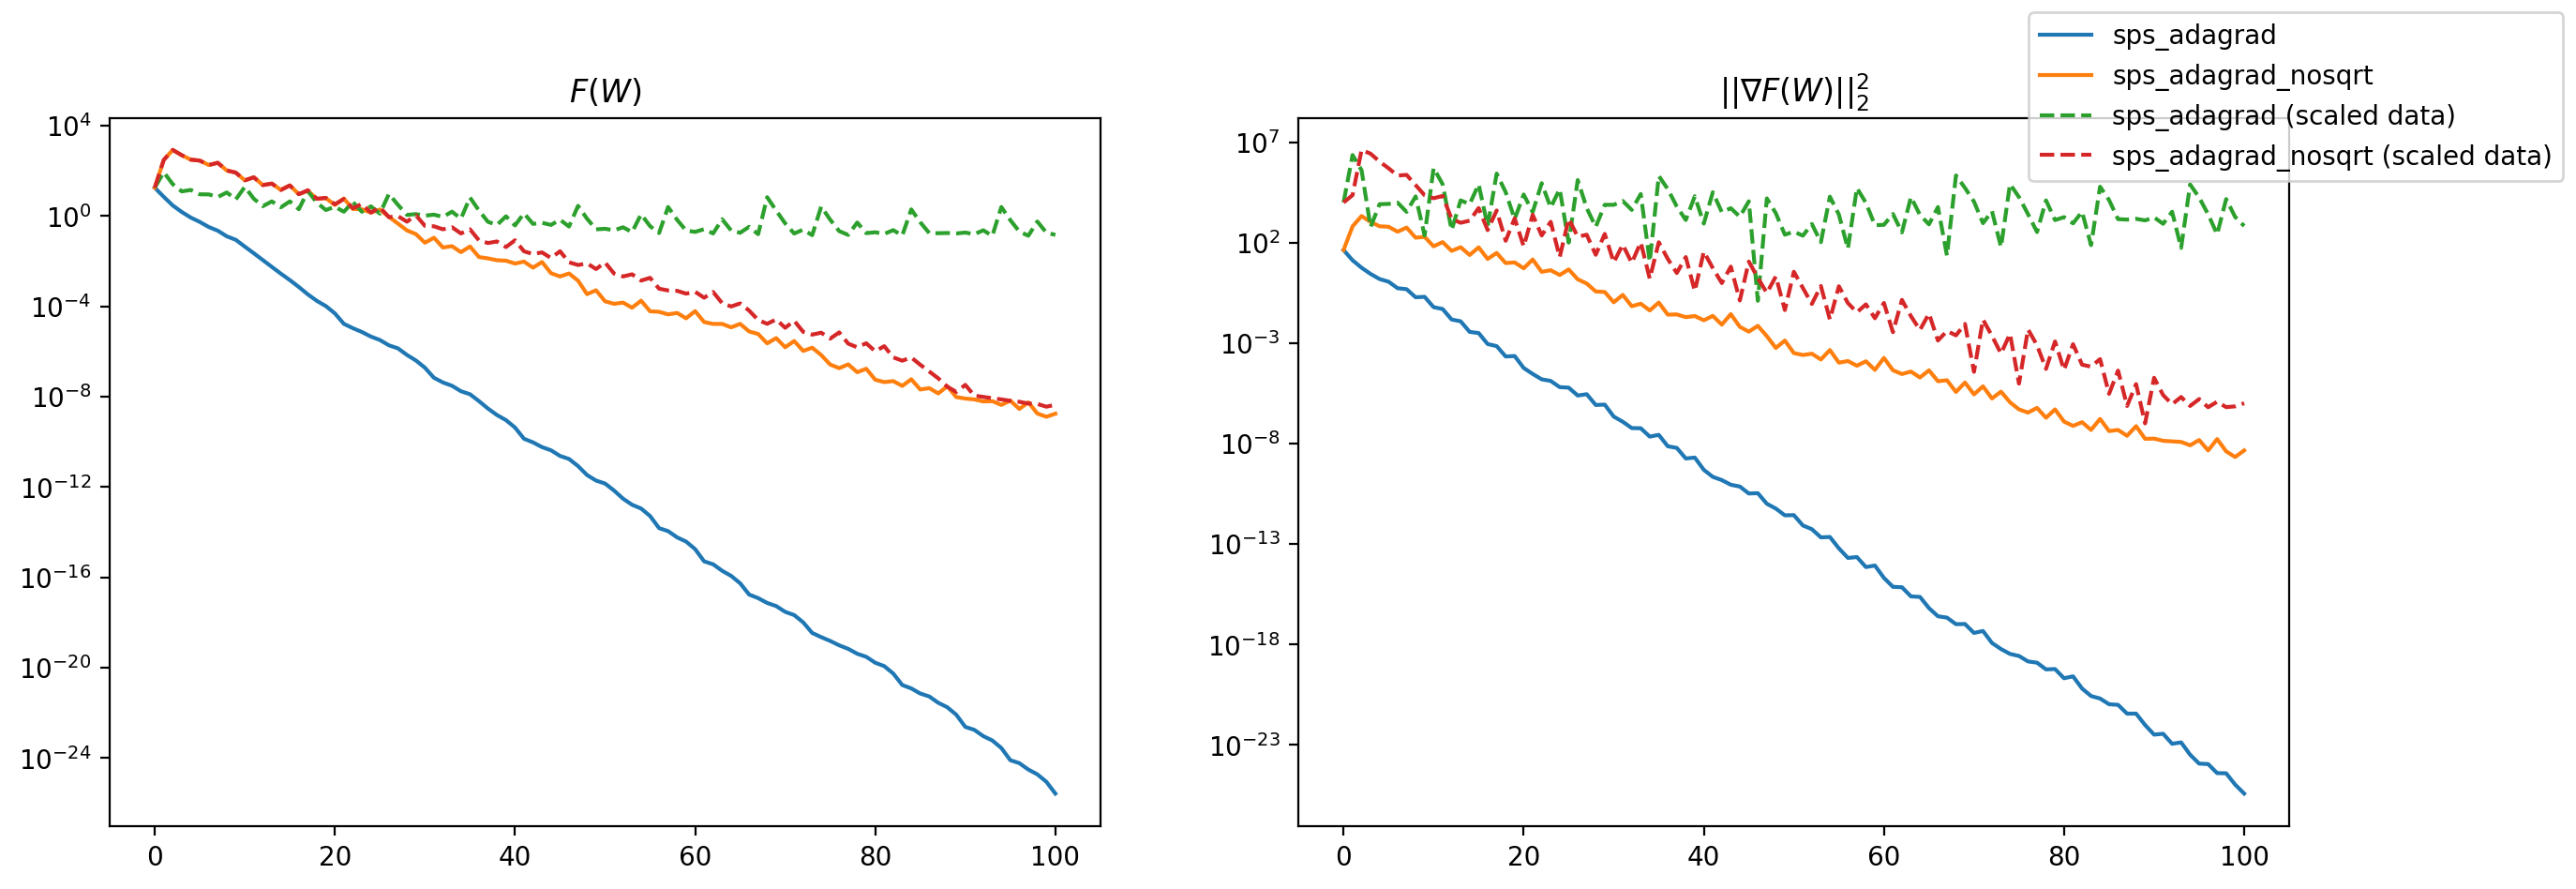

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=200)

ax1.semilogy([x[0] for x in hist_adagrad], label="sps_adagrad")
ax2.semilogy([x[1] for x in hist_adagrad])

ax1.semilogy([x[0] for x in hist_adagrad_nosqrt], label="sps_adagrad_nosqrt")
ax2.semilogy([x[1] for x in hist_adagrad_nosqrt])

ax1.semilogy([x[0] for x in hist_adagrad_scaled], linestyle="--", label="sps_adagrad (scaled data)")
ax2.semilogy([x[1] for x in hist_adagrad_scaled], linestyle="--")


ax1.semilogy([x[0] for x in hist_adagrad_nosqrt_scaled], linestyle="--", label="sps_adagrad_nosqrt (scaled data)")
ax2.semilogy([x[1] for x in hist_adagrad_nosqrt_scaled], linestyle="--")


ax1.set_title(r"$F(W)$")
ax2.set_title(r"$\|\| \nabla F(W) \|\|^2_2$")

fig.legend()

In [20]:
def ps_adam(train_data, train_target, train_dataloader, sqrt_=True):
    w = torch.zeros(train_data.shape[1])

    loss = func(w, train_data, train_target)
    g = grad(w, train_data, train_target)
    
    hist = [[loss.item(), torch.sum(torch.square(g)).item()]]

    betas = (0.9, 0.999)
    m = torch.zeros_like(g)
    v = torch.zeros_like(g)
    step_t = torch.tensor(0.)
    op = lambda x: torch.sqrt(x) if sqrt_ else x

    for epoch in range(EPOCHS):

        for batch_data, batch_target in train_dataloader:

            loss = func(w, batch_data, batch_target)
            g = grad(w, batch_data, batch_target)

            step_t += 1

            m = betas[0] * m + (1 - betas[0]) * g
            v = betas[1] * v + (1 - betas[1]) * g.square()
            m_hat = m / (1 - torch.pow(betas[0], step_t))
            v_hat = v / (1 - torch.pow(betas[1], step_t))
            
            precond_inv = 1 / (op(v_hat) + 1e-8)
            weighted_grad_norm =  torch.dot(g, precond_inv * g)
            ps = loss / weighted_grad_norm


            with torch.no_grad():
                w.sub_(ps * precond_inv * m_hat)
                
        
        loss = func(w, train_data, train_target)
        g = grad(w, train_data, train_target)

        hist.append([loss.item(), torch.sum(torch.square(g)).item()])

    return hist

In [21]:
hist_adam = ps_adam(train_data, train_target, train_dataloader, True)

In [22]:
hist_adam_nosqrt = ps_adam(train_data, train_target, train_dataloader, False)

In [23]:
hist_adam_scaled = ps_adam(train_data_scaled, train_target, train_dataloader_scaled, True)

In [24]:
hist_adam_nosqrt_scaled = ps_adam(train_data_scaled, train_target, train_dataloader_scaled, False)

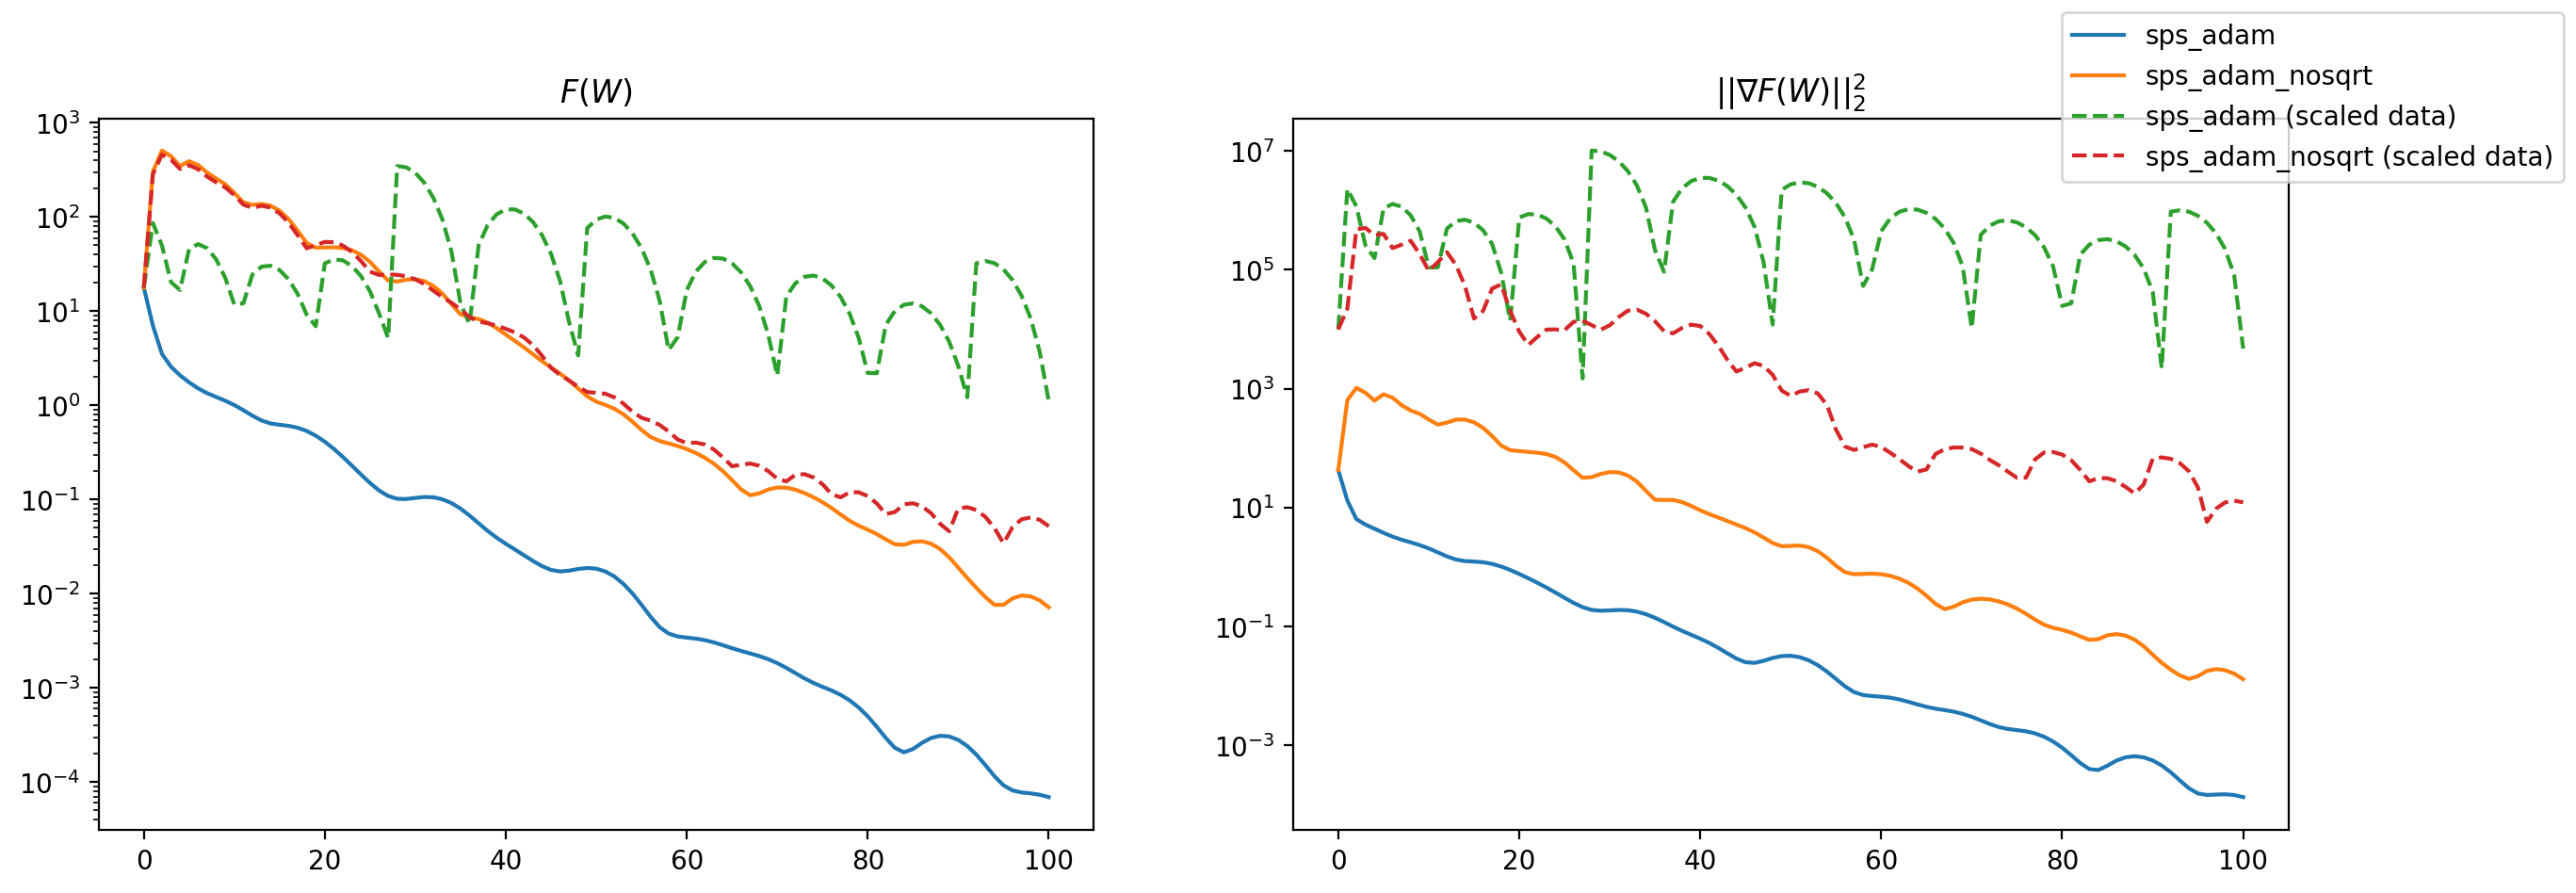

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=200)

ax1.semilogy([x[0] for x in hist_adam], label="sps_adam")
ax2.semilogy([x[1] for x in hist_adam])

ax1.semilogy([x[0] for x in hist_adam_nosqrt], label="sps_adam_nosqrt")
ax2.semilogy([x[1] for x in hist_adam_nosqrt])

ax1.semilogy([x[0] for x in hist_adam_scaled], linestyle="--", label="sps_adam (scaled data)")
ax2.semilogy([x[1] for x in hist_adam_scaled], linestyle="--")


ax1.semilogy([x[0] for x in hist_adam_nosqrt_scaled], linestyle="--", label="sps_adam_nosqrt (scaled data)")
ax2.semilogy([x[1] for x in hist_adam_nosqrt_scaled], linestyle="--")


ax1.set_title(r"$F(W)$")
ax2.set_title(r"$\|\| \nabla F(W) \|\|^2_2$")

fig.legend()

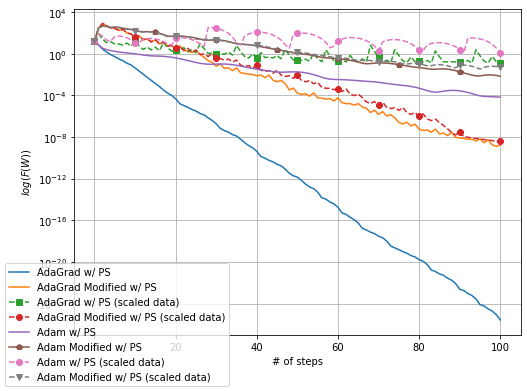

In [26]:
fig = plt.figure(figsize=(8, 6))

plt.semilogy([x[0] for x in hist_adagrad], label="AdaGrad w/ PS")
# ax2.semilogy([x[1] for x in hist_adagrad])

plt.semilogy([x[0] for x in hist_adagrad_nosqrt], label="AdaGrad Modified w/ PS")
# ax2.semilogy([x[1] for x in hist_adagrad_nosqrt])

markevery = [x for x in range(0, len(hist_adagrad_scaled), 10)]  
plt.semilogy([x[0] for x in hist_adagrad_scaled], linestyle="--",  marker="s", markevery=markevery, label="AdaGrad w/ PS (scaled data)")
# ax2.semilogy([x[1] for x in hist_adagrad_scaled], linestyle="--")

markevery = [x for x in range(0, len(hist_adagrad_nosqrt_scaled), 10)]  
plt.semilogy([x[0] for x in hist_adagrad_nosqrt_scaled], linestyle="--",  marker="8", markevery=markevery, label="AdaGrad Modified w/ PS (scaled data)")
# ax2.semilogy([x[1] for x in hist_adagrad_nosqrt_scaled], linestyle="--")


plt.semilogy([x[0] for x in hist_adam], label="Adam w/ PS")
# ax2.semilogy([x[1] for x in hist_adam])

markevery = [x for x in range(0, len(hist_adam_nosqrt), 15)]  
plt.semilogy([x[0] for x in hist_adam_nosqrt], marker="p", markevery=markevery, label="Adam Modified w/ PS")
# ax2.semilogy([x[1] for x in hist_adam_nosqrt])

markevery = [x for x in range(0, len(hist_adam_scaled), 10)]  
plt.semilogy([x[0] for x in hist_adam_scaled], linestyle="--", marker="o", markevery=markevery, label="Adam w/ PS (scaled data)")
# ax2.semilogy([x[1] for x in hist_adam_scaled], linestyle="--")

markevery = [x for x in range(0, len(hist_adam_nosqrt_scaled), 10)]  
plt.semilogy([x[0] for x in hist_adam_nosqrt_scaled], linestyle="--", marker="v", markevery=markevery, label="Adam Modified w/ PS (scaled data)")
# ax2.semilogy([x[1] for x in hist_adam_nosqrt_scaled], linestyle="--")

plt.xlabel("# of steps")
plt.ylabel(r"$log(F(W))$")
# ax2.set_title(r"$\|\| \nabla F(W) \|\|^2_2$")

plt.grid(True)
fig.legend(loc="lower left")

# plt.savefig("ada_ideal_precond_illustr.pdf", format="pdf")

In [27]:
def hess_diag_approx_test(weights, grad, iters, hessian_diag):
        Ds = torch.zeros_like(weights)
        diff = []
        for j in range(iters):
            z = rademacher_old(weights)
            with torch.no_grad():
                hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
            Ds.add_(hvp*z)

            if j % 1000 == 0:
                diff.append(torch.norm(hessian_diag - Ds.div(j)))

        return Ds.div(iters), diff

def hess_diag_approx_normaldist(weights, grad, iters, hessian_diag):
        Ds = torch.zeros_like(weights)
        diff = []
        for j in range(iters):
            # z = rademacher_old(weights)
            z = torch.randn_like(weights)
            with torch.no_grad():
                hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
            Ds.add_(hvp*z)

            if j % 1000 == 0:
                diff.append(torch.norm(hessian_diag - Ds.div(j)))

        return Ds.div(iters), diff

w = torch.zeros(A.shape[1]).requires_grad_()

loss = func(w, train_data, train_target)
g = torch.autograd.grad(loss, w, create_graph=True)[0]
# g = grad(w, train_data, train_target)


hessian = hess(train_data)
hessian_diag = torch.diag(hessian)
hessian_diag_inv = 1 / hessian_diag


# Hutch
beta = 0.999

D, diff = hess_diag_approx_test(w, g, 100000, hessian_diag)

D_normal, diff_normal = hess_diag_approx_normaldist(w, g, 100000, hessian_diag)

# v = hess_diag_approx(w, g, 1)

# Smoothing and Truncation 
# D = beta * D + (1 - beta) * v
# Dk_hat = torch.abs(Dk)
# Dk_hat[Dk_hat < alpha] = alpha
# Dk_hat_inv = 1 / Dk_hat


# hist = [[loss.item(), torch.sum(torch.square(g)).item()]]
    
# for epoch in range(EPOCHS):

#     for batch_data, batch_target in train_dataloader:

#         loss = func(w, batch_data, batch_target)
#         # g = grad(w, batch_data, batch_target)
#         g = torch.autograd.grad(loss, w, create_graph=True)[0]

#         v = hess_diag_approx(w, g, 1)

#         # Smoothing and Truncation 
#         D = beta * D + (1 - beta) * v
#         print(f"norm(hessian_diag - D_{100 + epoch + 1}) = {torch.norm(hessian_diag - D)}")

#         D_inv =  1 / D

#         precond = D_inv
#         weighted_grad_norm =  torch.dot(g, precond * g)

#         ps = loss / weighted_grad_norm

#         with torch.no_grad():
#             w.sub_(ps * precond * g)
    
#     loss = func(w, train_data, train_target)
#     g = grad(w, train_data, train_target)

#     hist.append([loss.item(), torch.sum(torch.square(g)).item()])


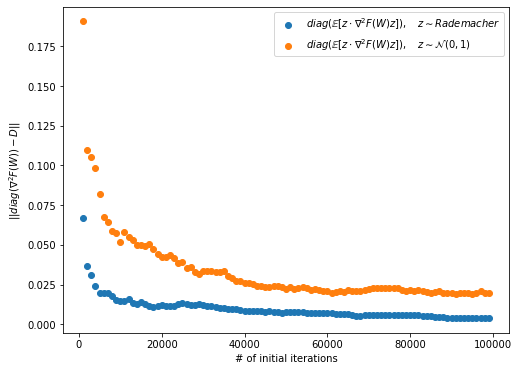

In [28]:
fig = plt.figure(figsize=(8, 6))

plt.scatter([x for x in range(0, 100000, 1000)], diff, label=r"$ diag( \mathbb{E} [ z \cdot \nabla^2 F(W)z ] ), \quad z \sim Rademacher $")
plt.scatter([x for x in range(0, 100000, 1000)], diff_normal, label=r"$ diag( \mathbb{E} [ z \cdot \nabla^2 F(W)z ] ), \quad z \sim \mathcal{N}(0, 1) $")


plt.ylabel(r"$\|\| diag(\nabla^2 F(W)) - D  \|\|$")
plt.xlabel("# of initial iterations")

plt.legend()

# plt.savefig("temptemptemptemp.svg", format="svg")


In [188]:
P_EPOCHS = 1000

In [189]:
torch.manual_seed(0)

w = torch.zeros(train_data.shape[1]).requires_grad_()

loss = func(w, train_data, train_target)
g = torch.autograd.grad(loss, w, create_graph=True)[0]
# g = grad(w, train_data, train_target)


hessian = hess(train_data)
hessian_diag = torch.diag(hessian)
hessian_diag_inv = 1 / hessian_diag


# Hutch
beta = 0.999

diff_hutch = []
D = hess_diag_approx(w, g, 100)
diff_hutch.append(torch.norm(hessian_diag - D).item())
print(f"norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")


# v = hess_diag_approx(w, g, 1)

# Smoothing and Truncation 
# D = beta * D + (1 - beta) * v
# Dk_hat = torch.abs(Dk)
# Dk_hat[Dk_hat < alpha] = alpha
# Dk_hat_inv = 1 / Dk_hat


hist_hutch = [[loss.item(), torch.sum(torch.square(g)).item()]]
    
for epoch in range(P_EPOCHS):

    for batch_data, batch_target in train_dataloader:

        loss = func(w, batch_data, batch_target)
        # g = grad(w, batch_data, batch_target)
        g = torch.autograd.grad(loss, w, create_graph=True)[0]

        v = hess_diag_approx(w, g, 1)

        # Smoothing and Truncation 
        D = beta * D + (1 - beta) * v

        D_inv =  1 / D

        precond = D_inv
        weighted_grad_norm =  torch.dot(g, precond * g)

        ps = loss / weighted_grad_norm

        with torch.no_grad():
            w.sub_(ps * precond * g)

    print(f"{epoch + 1} / {P_EPOCHS}: norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")
    diff_hutch.append(torch.norm(hessian_diag - D).item())
    
    loss = func(w, train_data, train_target)
    g = grad(w, train_data, train_target)

    hist_hutch.append([loss.item(), torch.sum(torch.square(g)).item()])


norm(hessian_diag - D) = 0.17144880332707804
1 / 1000: norm(hessian_diag - D) = 0.171329510969218
2 / 1000: norm(hessian_diag - D) = 0.17143490329440458
3 / 1000: norm(hessian_diag - D) = 0.1714953851503041
4 / 1000: norm(hessian_diag - D) = 0.1710441312816847
5 / 1000: norm(hessian_diag - D) = 0.17132027265199448
6 / 1000: norm(hessian_diag - D) = 0.17119927934914148
7 / 1000: norm(hessian_diag - D) = 0.17056937140393344
8 / 1000: norm(hessian_diag - D) = 0.1707995111899358
9 / 1000: norm(hessian_diag - D) = 0.17031115717267029
10 / 1000: norm(hessian_diag - D) = 0.16989136927206014
11 / 1000: norm(hessian_diag - D) = 0.16977910821278297
12 / 1000: norm(hessian_diag - D) = 0.16996025663613984
13 / 1000: norm(hessian_diag - D) = 0.170138800942921
14 / 1000: norm(hessian_diag - D) = 0.16907462701891068
15 / 1000: norm(hessian_diag - D) = 0.1682727592830039
16 / 1000: norm(hessian_diag - D) = 0.1690476912364476
17 / 1000: norm(hessian_diag - D) = 0.1689216744910106
18 / 1000: norm(hessia

In [190]:
torch.manual_seed(0)

w = torch.zeros(train_data.shape[1]).requires_grad_()

loss = func(w, train_data, train_target)
g = torch.autograd.grad(loss, w, create_graph=True)[0]
# g = grad(w, train_data, train_target)

diff_hutch_sqrt = []

D = hess_diag_approx(w, g, 100)
diff_hutch_sqrt.append(torch.norm(hessian_diag - D).item())
print(f"norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")


v = hess_diag_approx(w, g, 1)

# Smoothing and Truncation 
D = torch.sqrt(beta * D + (1 - beta) * v)
# Dk_hat = torch.abs(Dk)
# Dk_hat[Dk_hat < alpha] = alpha
# Dk_hat_inv = 1 / Dk_hat


hist_hutch_sqrt = [[loss.item(), torch.sum(torch.square(g)).item()]]
    
for epoch in range(P_EPOCHS):

    for batch_data, batch_target in train_dataloader:

        loss = func(w, batch_data, batch_target)
        # g = grad(w, batch_data, batch_target)
        g = torch.autograd.grad(loss, w, create_graph=True)[0]

        v = hess_diag_approx(w, g, 1)

        # Smoothing and Truncation 
        D = torch.sqrt(beta * D + (1 - beta) * v)
        
        D_inv =  1 / D

        precond = D_inv
        weighted_grad_norm =  torch.dot(g, precond * g)

        ps = loss / weighted_grad_norm

        with torch.no_grad():
            w.sub_(ps * precond * g)

    diff_hutch_sqrt.append(torch.norm(hessian_diag - D).item())
    print(f"{epoch + 1} / {P_EPOCHS}: norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")
    
    loss = func(w, train_data, train_target)
    g = grad(w, train_data, train_target)

    hist_hutch_sqrt.append([loss.item(), torch.sum(torch.square(g)).item()])


norm(hessian_diag - D) = 0.17144880332707804
1 / 1000: norm(hessian_diag - D) = 0.45687607113439094
2 / 1000: norm(hessian_diag - D) = 0.5338692165273387
3 / 1000: norm(hessian_diag - D) = 0.5731603346846074
4 / 1000: norm(hessian_diag - D) = 0.592774140468169
5 / 1000: norm(hessian_diag - D) = 0.603057893171176
6 / 1000: norm(hessian_diag - D) = 0.607852924886225
7 / 1000: norm(hessian_diag - D) = 0.6099081162275446
8 / 1000: norm(hessian_diag - D) = 0.610919527660001
9 / 1000: norm(hessian_diag - D) = 0.611668579694726
10 / 1000: norm(hessian_diag - D) = 0.6123490606748141
11 / 1000: norm(hessian_diag - D) = 0.6126444521758214
12 / 1000: norm(hessian_diag - D) = 0.612478554755501
13 / 1000: norm(hessian_diag - D) = 0.6126791086165404
14 / 1000: norm(hessian_diag - D) = 0.6129404627357791
15 / 1000: norm(hessian_diag - D) = 0.6129415269590766
16 / 1000: norm(hessian_diag - D) = 0.6130710698847389
17 / 1000: norm(hessian_diag - D) = 0.6126929499635335
18 / 1000: norm(hessian_diag - D) 

In [191]:
torch.manual_seed(0)

w = torch.zeros(train_data.shape[1]).requires_grad_()

loss = func(w, train_data, train_target)
g = torch.autograd.grad(loss, w, create_graph=True)[0]
# g = grad(w, train_data, train_target)

diff_adahessian = []

D = hess_diag_approx(w, g, 100)
D_sum = D.detach().clone()
diff_adahessian.append(torch.norm(hessian_diag - D).item())
k = 1
print(f"norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")

v = torch.square(hess_diag_approx(w, g, 1))
D_sum = D_sum + (beta**k * v)


hist_adahessian = [[loss.item(), torch.sum(torch.square(g)).item()]]
    
for epoch in range(P_EPOCHS):

    for batch_data, batch_target in train_dataloader:

        loss = func(w, batch_data, batch_target)
        # g = grad(w, batch_data, batch_target)
        g = torch.autograd.grad(loss, w, create_graph=True)[0]

        v = torch.square(hess_diag_approx(w, g, 1))
        D_sum = D_sum + (beta**k * v)
        t = (1 - beta) / (1 - beta**k) 
        D = torch.sqrt( t * D_sum )

        k += 1
        
        D_inv =  1 / D

        precond = D_inv
        weighted_grad_norm =  torch.dot(g, precond * g)

        ps = loss / weighted_grad_norm

        with torch.no_grad():
            w.sub_(ps * precond * g)

    diff_adahessian.append(torch.norm(hessian_diag - D).item())
    print(f"{epoch + 1} / {P_EPOCHS}: norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")
    
    loss = func(w, train_data, train_target)
    g = grad(w, train_data, train_target)

    hist_adahessian.append([loss.item(), torch.sum(torch.square(g)).item()])


norm(hessian_diag - D) = 0.17144880332707804
1 / 1000: norm(hessian_diag - D) = 3.7779752422250357
2 / 1000: norm(hessian_diag - D) = 2.158686504216549
3 / 1000: norm(hessian_diag - D) = 1.601790449796938
4 / 1000: norm(hessian_diag - D) = 1.3291512690292595
5 / 1000: norm(hessian_diag - D) = 1.1363846764154883
6 / 1000: norm(hessian_diag - D) = 0.9581936372886165
7 / 1000: norm(hessian_diag - D) = 1.018861068762408
8 / 1000: norm(hessian_diag - D) = 0.9196380685592045
9 / 1000: norm(hessian_diag - D) = 0.8950082264427094
10 / 1000: norm(hessian_diag - D) = 0.8121212521435357
11 / 1000: norm(hessian_diag - D) = 0.7874470633442272
12 / 1000: norm(hessian_diag - D) = 0.7810199128085712
13 / 1000: norm(hessian_diag - D) = 0.8278664152012339
14 / 1000: norm(hessian_diag - D) = 0.7693927335434914
15 / 1000: norm(hessian_diag - D) = 0.6887867206834201
16 / 1000: norm(hessian_diag - D) = 0.6124457615322978
17 / 1000: norm(hessian_diag - D) = 0.5741332682468004
18 / 1000: norm(hessian_diag - D

In [192]:
torch.manual_seed(0)

w = torch.zeros(train_data.shape[1]).requires_grad_()

loss = func(w, train_data, train_target)
g = torch.autograd.grad(loss, w, create_graph=True)[0]
# g = grad(w, train_data, train_target)

diff_adahessian_nosqrt = []

D = hess_diag_approx(w, g, 100)
D_sum = D.detach().clone()
diff_adahessian_nosqrt.append(torch.norm(hessian_diag - D).item())
k = 1
print(f"norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")

v = torch.square(hess_diag_approx(w, g, 1))
D_sum = D_sum + (beta**k * v)

hist_adahessian_nosqrt = [[loss.item(), torch.sum(torch.square(g)).item()]]
    
for epoch in range(P_EPOCHS):

    for batch_data, batch_target in train_dataloader:

        loss = func(w, batch_data, batch_target)
        # g = grad(w, batch_data, batch_target)
        g = torch.autograd.grad(loss, w, create_graph=True)[0]

        v = torch.square(hess_diag_approx(w, g, 1))
        D_sum = D_sum + (beta**k * v)
        t = (1 - beta) / (1 - beta**k) 
        D = t * D_sum 

        k += 1

        D_inv =  1 / D

        precond = D_inv
        weighted_grad_norm =  torch.dot(g, precond * g)

        ps = loss / weighted_grad_norm

        with torch.no_grad():
            w.sub_(ps * precond * g)
    
    diff_adahessian_nosqrt.append(torch.norm(hessian_diag - D).item())
    print(f"{epoch + 1} / {P_EPOCHS}: norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")
    
    loss = func(w, train_data, train_target)
    g = grad(w, train_data, train_target)

    hist_adahessian_nosqrt.append([loss.item(), torch.sum(torch.square(g)).item()])


norm(hessian_diag - D) = 0.17144880332707804
1 / 1000: norm(hessian_diag - D) = 12.06097508126537
2 / 1000: norm(hessian_diag - D) = 6.330258066909173
3 / 1000: norm(hessian_diag - D) = 4.428556063328549
4 / 1000: norm(hessian_diag - D) = 3.6588858752380453
5 / 1000: norm(hessian_diag - D) = 3.0242515851154246
6 / 1000: norm(hessian_diag - D) = 2.569905523114372
7 / 1000: norm(hessian_diag - D) = 2.77889299913452
8 / 1000: norm(hessian_diag - D) = 2.5600624081289096
9 / 1000: norm(hessian_diag - D) = 2.476014107776758
10 / 1000: norm(hessian_diag - D) = 2.260359047537322
11 / 1000: norm(hessian_diag - D) = 2.13458466746848
12 / 1000: norm(hessian_diag - D) = 2.1381170988070832
13 / 1000: norm(hessian_diag - D) = 2.2461607482784895
14 / 1000: norm(hessian_diag - D) = 2.064830454646753
15 / 1000: norm(hessian_diag - D) = 1.854351413946199
16 / 1000: norm(hessian_diag - D) = 1.6597097599404735
17 / 1000: norm(hessian_diag - D) = 1.5892347410543648
18 / 1000: norm(hessian_diag - D) = 1.573

In [193]:
torch.manual_seed(0)

w = torch.zeros(train_data.shape[1]).requires_grad_()

loss = func(w, train_data, train_target)
g = torch.autograd.grad(loss, w, create_graph=True)[0]
# g = grad(w, train_data, train_target)

diff_adagrad = []

D_sum = torch.zeros(train_data.shape[1])
D = torch.sqrt(D_sum)
diff_adagrad.append(torch.norm(hessian_diag - D).item())
print(f"norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")

hist_adagrad = [[loss.item(), torch.sum(torch.square(g)).item()]]
    
for epoch in range(P_EPOCHS):

    for batch_data, batch_target in train_dataloader:

        loss = func(w, batch_data, batch_target)
        # g = grad(w, batch_data, batch_target)
        g = torch.autograd.grad(loss, w, create_graph=True)[0]

        D_sum += torch.square(g)
        D = torch.sqrt(D_sum)

        D_inv =  1 / D

        precond = D_inv
        weighted_grad_norm =  torch.dot(g, precond * g)

        ps = loss / weighted_grad_norm

        with torch.no_grad():
            w.sub_(ps * precond * g)
    
    diff_adagrad.append(torch.norm(hessian_diag - D).item())
    print(f"{epoch + 1} / {P_EPOCHS}: norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")
    
    loss = func(w, train_data, train_target)
    g = grad(w, train_data, train_target)

    hist_adagrad.append([loss.item(), torch.sum(torch.square(g)).item()])


norm(hessian_diag - D) = 4.5945870286186645
1 / 1000: norm(hessian_diag - D) = 3.9289256619083024
2 / 1000: norm(hessian_diag - D) = 4.4789336335563465
3 / 1000: norm(hessian_diag - D) = 4.814064487233356
4 / 1000: norm(hessian_diag - D) = 4.930681583170912
5 / 1000: norm(hessian_diag - D) = 5.001603669358687
6 / 1000: norm(hessian_diag - D) = 5.047196098222313
7 / 1000: norm(hessian_diag - D) = 5.070902103824256
8 / 1000: norm(hessian_diag - D) = 5.087293161339308
9 / 1000: norm(hessian_diag - D) = 5.09721194023738
10 / 1000: norm(hessian_diag - D) = 5.102341087889879
11 / 1000: norm(hessian_diag - D) = 5.106260917042692
12 / 1000: norm(hessian_diag - D) = 5.107448439798542
13 / 1000: norm(hessian_diag - D) = 5.108391118857787
14 / 1000: norm(hessian_diag - D) = 5.108670348215262
15 / 1000: norm(hessian_diag - D) = 5.108894973284238
16 / 1000: norm(hessian_diag - D) = 5.108961456308249
17 / 1000: norm(hessian_diag - D) = 5.10901772744272
18 / 1000: norm(hessian_diag - D) = 5.109033625

In [194]:
torch.manual_seed(0)

w = torch.zeros(train_data.shape[1]).requires_grad_()

loss = func(w, train_data, train_target)
g = torch.autograd.grad(loss, w, create_graph=True)[0]
# g = grad(w, train_data, train_target)

diff_adagrad_nosqrt = []

D_sum = torch.zeros(train_data.shape[1])
D = D_sum
diff_adagrad_nosqrt.append(torch.norm(hessian_diag - D).item())
print(f"norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")

hist_adagrad_nosqrt = [[loss.item(), torch.sum(torch.square(g)).item()]]
    
for epoch in range(P_EPOCHS):

    for batch_data, batch_target in train_dataloader:

        loss = func(w, batch_data, batch_target)
        # g = grad(w, batch_data, batch_target)
        g = torch.autograd.grad(loss, w, create_graph=True)[0]

        D_sum += torch.square(g)
        D = D_sum

        D_inv =  1 / D

        precond = D_inv
        weighted_grad_norm =  torch.dot(g, precond * g)

        ps = loss / weighted_grad_norm

        with torch.no_grad():
            w.sub_(ps * precond * g)

    
    diff_adagrad_nosqrt.append(torch.norm(hessian_diag - D).item())
    print(f"{epoch + 1} / {P_EPOCHS}: norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")

    loss = func(w, train_data, train_target)
    g = grad(w, train_data, train_target)

    hist_adagrad_nosqrt.append([loss.item(), torch.sum(torch.square(g)).item()])


norm(hessian_diag - D) = 4.5945870286186645
1 / 1000: norm(hessian_diag - D) = 12.519789168477818
2 / 1000: norm(hessian_diag - D) = 512.7492795756527
3 / 1000: norm(hessian_diag - D) = 1012.736121453867
4 / 1000: norm(hessian_diag - D) = 1402.3128515702438
5 / 1000: norm(hessian_diag - D) = 1727.7199063916748
6 / 1000: norm(hessian_diag - D) = 1963.2086554609607
7 / 1000: norm(hessian_diag - D) = 2174.8714908717734
8 / 1000: norm(hessian_diag - D) = 2331.8564149746203
9 / 1000: norm(hessian_diag - D) = 2461.6313980003224
10 / 1000: norm(hessian_diag - D) = 2527.1165939777907
11 / 1000: norm(hessian_diag - D) = 2575.543515707999
12 / 1000: norm(hessian_diag - D) = 2607.5555096717044
13 / 1000: norm(hessian_diag - D) = 2635.717824383477
14 / 1000: norm(hessian_diag - D) = 2659.1016418055037
15 / 1000: norm(hessian_diag - D) = 2677.191451284724
16 / 1000: norm(hessian_diag - D) = 2693.297980443374
17 / 1000: norm(hessian_diag - D) = 2705.0759603439924
18 / 1000: norm(hessian_diag - D) = 

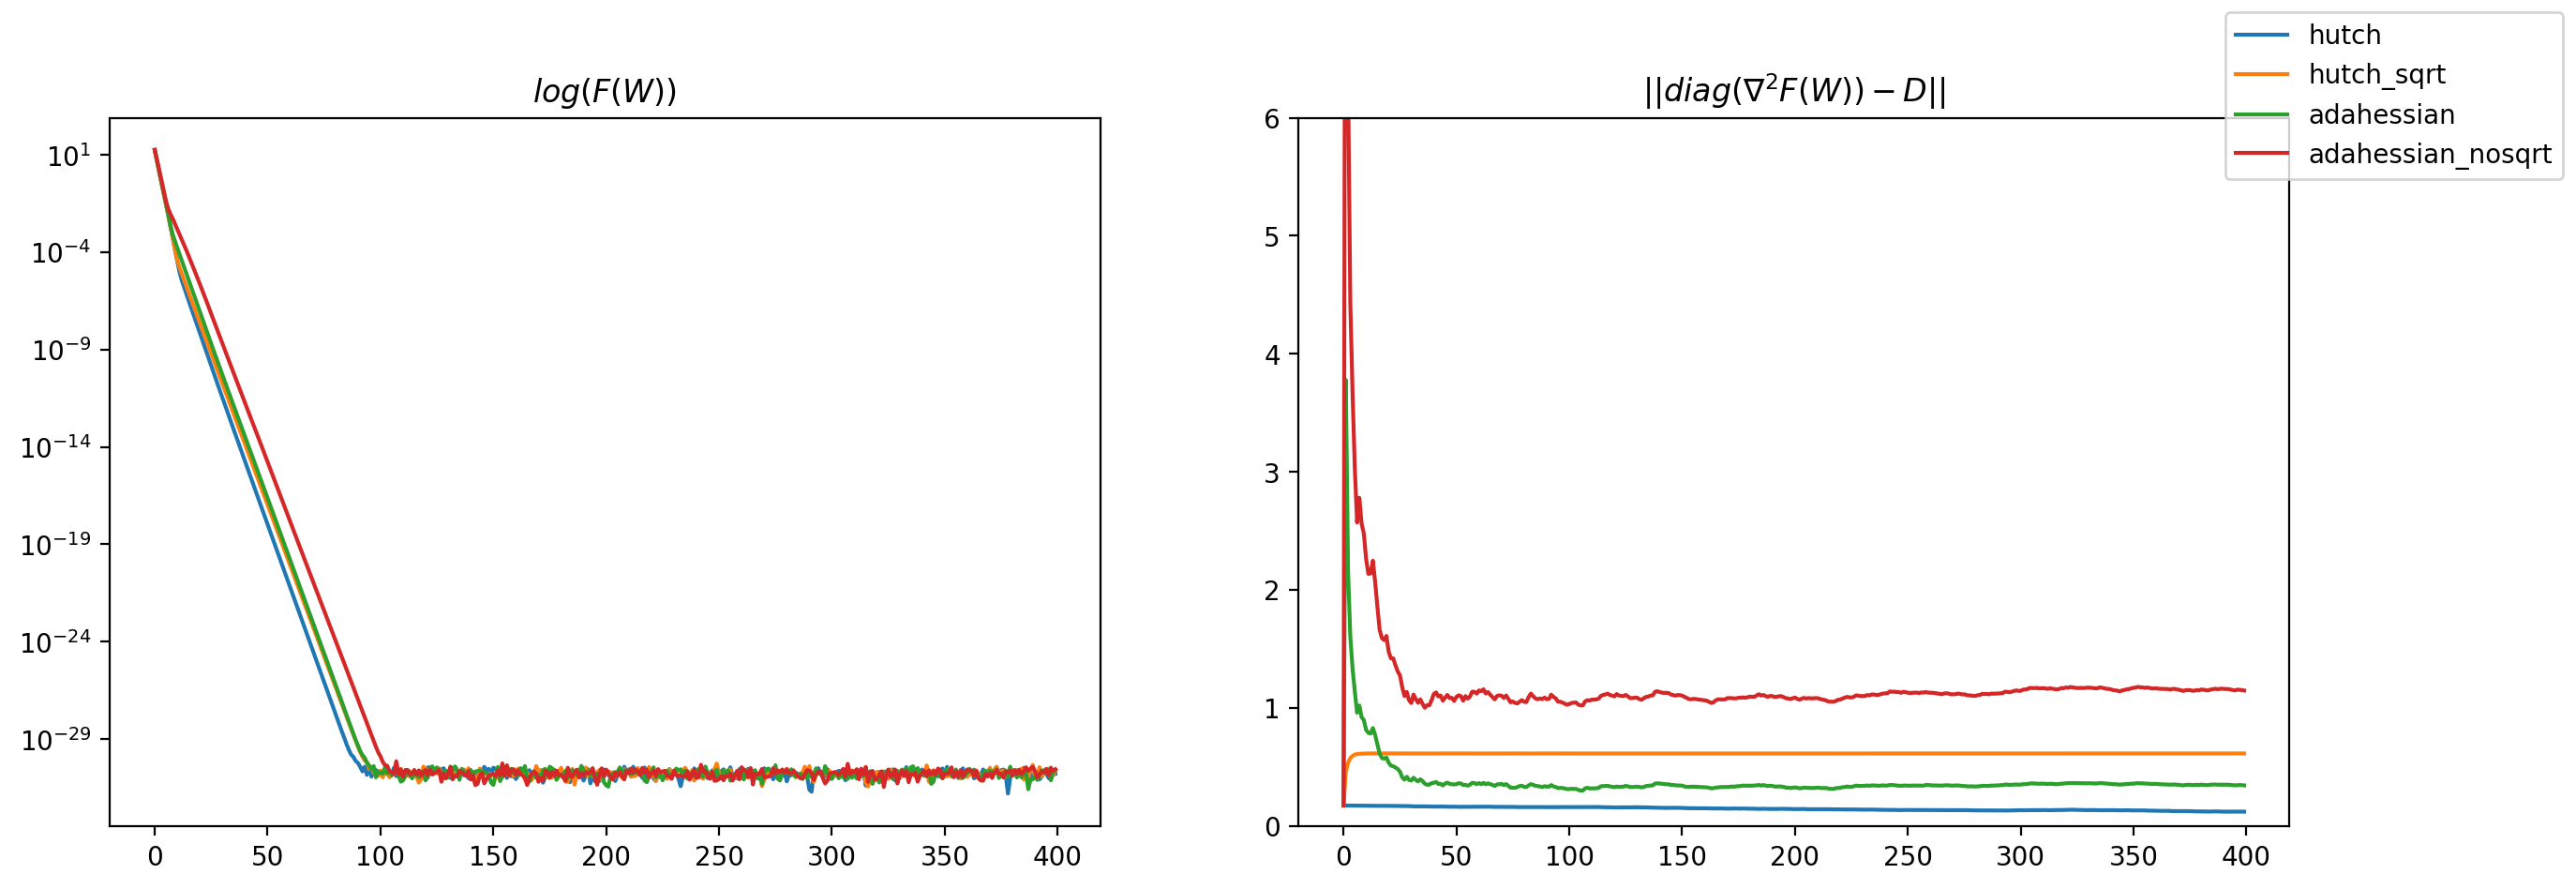

In [195]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=200)

trunc = 400

ax1.semilogy([x[0] for x in hist_hutch[:trunc]])
ax1.semilogy([x[0] for x in hist_hutch_sqrt[:trunc]])
ax1.semilogy([x[0] for x in hist_adahessian[:trunc]])
ax1.semilogy([x[0] for x in hist_adahessian_nosqrt[:trunc]])

ax2.plot(diff_hutch[:trunc])
ax2.plot(diff_hutch_sqrt[:trunc])
ax2.plot(diff_adahessian[:trunc])
ax2.plot(diff_adahessian_nosqrt[:trunc])

ax1.set_title(r"$ log(F(W)) $")
ax2.set_title(r"$\|\| diag(\nabla^2 F(W)) - D  \|\|$")

ax2.set_ylim(0, 6)

fig.legend(["hutch", "hutch_sqrt", "adahessian", "adahessian_nosqrt"])

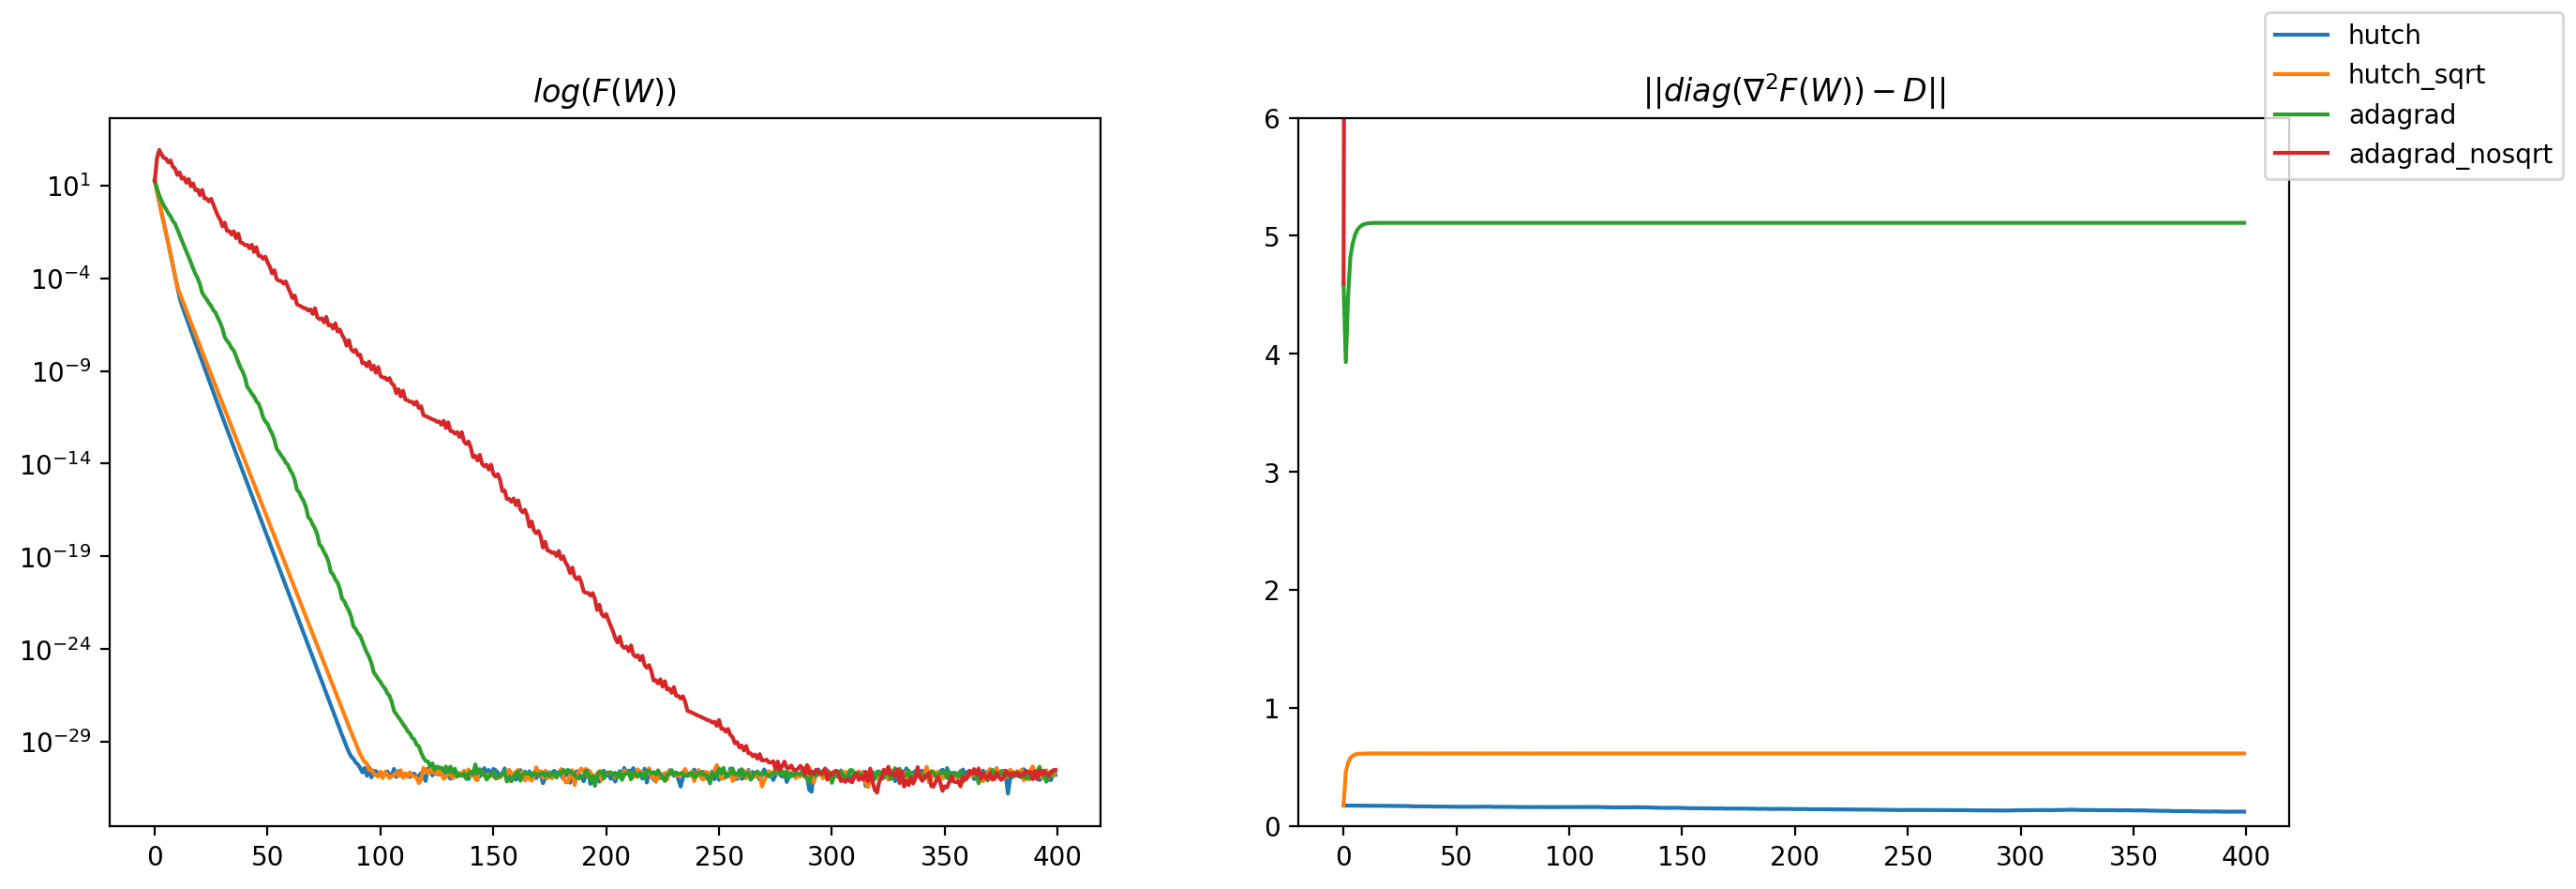

In [196]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=200)

trunc = 400

ax1.semilogy([x[0] for x in hist_hutch[:trunc]])
ax1.semilogy([x[0] for x in hist_hutch_sqrt[:trunc]])
ax1.semilogy([x[0] for x in hist_adagrad[:trunc]])
ax1.semilogy([x[0] for x in hist_adagrad_nosqrt[:trunc]])

ax2.plot(diff_hutch[:trunc])
ax2.plot(diff_hutch_sqrt[:trunc])
ax2.plot(diff_adagrad[:trunc])
ax2.plot(diff_adagrad_nosqrt[:trunc])

ax1.set_title(r"$ log(F(W)) $")
ax2.set_title(r"$\|\| diag(\nabla^2 F(W)) - D  \|\|$")

ax2.set_ylim(0, 6)

fig.legend(["hutch", "hutch_sqrt", "adagrad", "adagrad_nosqrt"])

In [197]:
torch.manual_seed(0)

w = torch.zeros(train_data.shape[1]).requires_grad_()

loss = func(w, train_data, train_target)
g = torch.autograd.grad(loss, w, create_graph=True)[0]
# g = grad(w, train_data, train_target)

diff_adam = []

D = torch.zeros_like(g)
D_sum =  torch.zeros_like(g)
k = 1
diff_adam.append(torch.norm(hessian_diag - D).item())
print(f"norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")

hist_adam = [[loss.item(), torch.sum(torch.square(g)).item()]]
    
for epoch in range(P_EPOCHS):

    for batch_data, batch_target in train_dataloader:

        loss = func(w, batch_data, batch_target)
        # g = grad(w, batch_data, batch_target)
        g = torch.autograd.grad(loss, w, create_graph=True)[0]

        D_sum =  D_sum + (beta**k) * torch.square(g)
        t = (1 - beta) / (1 - beta**k)
        D = torch.sqrt( t * D_sum )

        k += 1

        D_inv =  1 / D

        precond = D_inv
        weighted_grad_norm =  torch.dot(g, precond * g)

        ps = loss / weighted_grad_norm

        with torch.no_grad():
            w.sub_(ps * precond * g)

    diff_adam.append(torch.norm(hessian_diag - D).item())
    print(f"{epoch + 1} / {P_EPOCHS}: norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")
    
    loss = func(w, train_data, train_target)
    g = grad(w, train_data, train_target)

    hist_adam.append([loss.item(), torch.sum(torch.square(g)).item()])


norm(hessian_diag - D) = 4.5945870286186645
1 / 1000: norm(hessian_diag - D) = 3.9265649829640696
2 / 1000: norm(hessian_diag - D) = 2.9619810084887983
3 / 1000: norm(hessian_diag - D) = 2.6972108677314828
4 / 1000: norm(hessian_diag - D) = 2.5742836923772643
5 / 1000: norm(hessian_diag - D) = 2.563771312924517
6 / 1000: norm(hessian_diag - D) = 2.58934336664575
7 / 1000: norm(hessian_diag - D) = 2.639920677022257
8 / 1000: norm(hessian_diag - D) = 2.692023298059728
9 / 1000: norm(hessian_diag - D) = 2.7514550185898368
10 / 1000: norm(hessian_diag - D) = 2.804905723148234
11 / 1000: norm(hessian_diag - D) = 2.859542423212905
12 / 1000: norm(hessian_diag - D) = 2.909420140637506
13 / 1000: norm(hessian_diag - D) = 2.956814333850277
14 / 1000: norm(hessian_diag - D) = 3.0006131108471163
15 / 1000: norm(hessian_diag - D) = 3.0415684456095637
16 / 1000: norm(hessian_diag - D) = 3.079648416576613
17 / 1000: norm(hessian_diag - D) = 3.115234544695634
18 / 1000: norm(hessian_diag - D) = 3.148

In [198]:
torch.manual_seed(0)

w = torch.zeros(train_data.shape[1]).requires_grad_()

loss = func(w, train_data, train_target)
g = torch.autograd.grad(loss, w, create_graph=True)[0]
# g = grad(w, train_data, train_target)

diff_adam_nosqrt = []

D = torch.zeros_like(g)
D_sum =  torch.zeros_like(g)
k = 1
diff_adam_nosqrt.append(torch.norm(hessian_diag - D).item())
print(f"norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")

hist_adam_nosqrt = [[loss.item(), torch.sum(torch.square(g)).item()]]
    
for epoch in range(P_EPOCHS):

    for batch_data, batch_target in train_dataloader:

        loss = func(w, batch_data, batch_target)
        # g = grad(w, batch_data, batch_target)
        g = torch.autograd.grad(loss, w, create_graph=True)[0]

        D_sum =  D_sum + (beta**k) * torch.square(g)
        t = (1 - beta) / (1 - beta**k)
        D = t * D_sum

        k += 1

        D_inv =  1 / D

        precond = D_inv
        weighted_grad_norm =  torch.dot(g, precond * g)

        ps = loss / weighted_grad_norm

        with torch.no_grad():
            w.sub_(ps * precond * g)

    diff_adam_nosqrt.append(torch.norm(hessian_diag - D).item())
    print(f"{epoch + 1} / {P_EPOCHS}: norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")
    
    loss = func(w, train_data, train_target)
    g = grad(w, train_data, train_target)

    hist_adam_nosqrt.append([loss.item(), torch.sum(torch.square(g)).item()])


norm(hessian_diag - D) = 4.5945870286186645
1 / 1000: norm(hessian_diag - D) = 12.50554293255121
2 / 1000: norm(hessian_diag - D) = 255.36276307499648
3 / 1000: norm(hessian_diag - D) = 335.0784642153287
4 / 1000: norm(hessian_diag - D) = 347.84315829263386
5 / 1000: norm(hessian_diag - D) = 342.8737724888703
6 / 1000: norm(hessian_diag - D) = 324.54155074834944
7 / 1000: norm(hessian_diag - D) = 308.1593930709365
8 / 1000: norm(hessian_diag - D) = 288.94764036875256
9 / 1000: norm(hessian_diag - D) = 271.12198228921784
10 / 1000: norm(hessian_diag - D) = 250.33113044364245
11 / 1000: norm(hessian_diag - D) = 231.829125290204
12 / 1000: norm(hessian_diag - D) = 215.06029931187055
13 / 1000: norm(hessian_diag - D) = 200.56915478614974
14 / 1000: norm(hessian_diag - D) = 187.80722210797333
15 / 1000: norm(hessian_diag - D) = 176.39793900246235
16 / 1000: norm(hessian_diag - D) = 166.32378564341028
17 / 1000: norm(hessian_diag - D) = 157.18351122531212
18 / 1000: norm(hessian_diag - D) = 

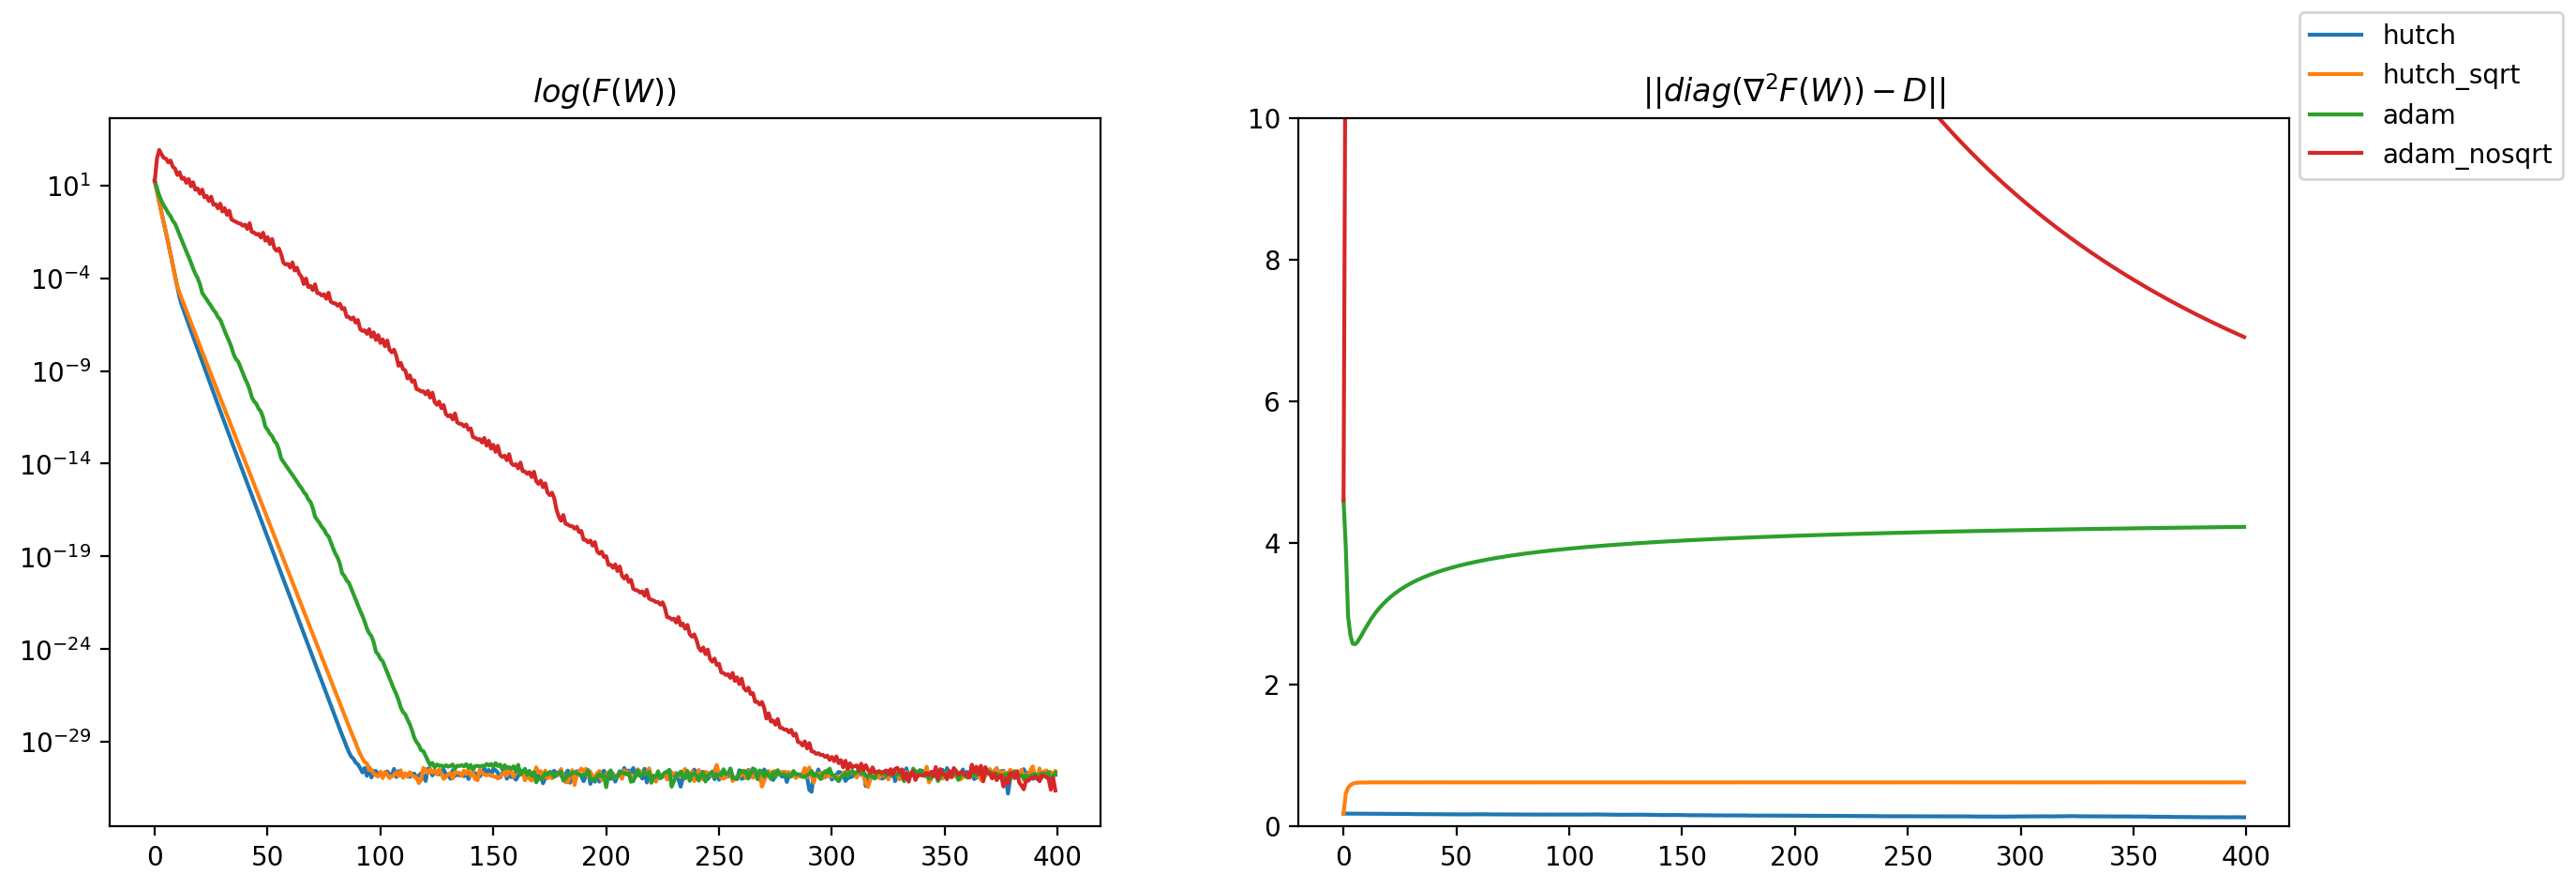

In [199]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=200)

ax1_trunc = 400
ax2_trunc = 400

ax1.semilogy([x[0] for x in hist_hutch[:ax1_trunc]])
ax1.semilogy([x[0] for x in hist_hutch_sqrt[:ax1_trunc]])
ax1.semilogy([x[0] for x in hist_adam[:ax1_trunc]])
ax1.semilogy([x[0] for x in hist_adam_nosqrt[:ax1_trunc]])

ax2.plot(diff_hutch[:ax2_trunc])
ax2.plot(diff_hutch_sqrt[:ax2_trunc])
ax2.plot(diff_adam[:ax2_trunc])
ax2.plot(diff_adam_nosqrt[:ax2_trunc])

ax1.set_title(r"$ log(F(W)) $")
ax2.set_title(r"$\|\| diag(\nabla^2 F(W)) - D  \|\|$")

ax2.set_ylim(0, 10)

fig.legend(["hutch", "hutch_sqrt", "adam", "adam_nosqrt"])

In [232]:
# Hutch
beta = 0.999
alpha = 0.1
hutch_init = 100

In [240]:
def hess_diag_approx_hutch(weights, grad, iters):
    Ds = torch.zeros_like(weights)
    for j in range(iters):
        z = rademacher_old(weights)
        with torch.no_grad():
            hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
        Ds.add_(hvp*z)

    return Ds.div(iters)

torch.manual_seed(0)

w = torch.zeros(train_data.shape[1]).requires_grad_()

loss = func(w, train_data, train_target)
g = torch.autograd.grad(loss, w, create_graph=True)[0]
# g = grad(w, train_data, train_target)


hessian = hess(train_data)
hessian_diag = torch.diag(hessian)
hessian_diag_inv = 1 / hessian_diag


diff_hutch = []
D = hess_diag_approx_hutch(w, g, hutch_init)
diff_hutch.append(torch.norm(hessian_diag - D).item())
print(f"norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")


hist_hutch = [[loss.item(), torch.sum(torch.square(g)).item()]]
    
for epoch in range(P_EPOCHS):

    for batch_data, batch_target in train_dataloader:

        loss = func(w, batch_data, batch_target)
        # g = grad(w, batch_data, batch_target)
        g = torch.autograd.grad(loss, w, create_graph=True)[0]

        v = hess_diag_approx_hutch(w, g, 1)

        # Smoothing and Truncation 
        D = beta * D + (1 - beta) * v

        D_inv =  1 / D

        precond = D_inv
        weighted_grad_norm =  torch.dot(g, precond * g)

        ps = loss / weighted_grad_norm

        with torch.no_grad():
            w.sub_(ps * precond * g)

    print(f"{epoch + 1} / {P_EPOCHS}: norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")
    diff_hutch.append(torch.norm(hessian_diag - D).item())
    
    loss = func(w, train_data, train_target)
    g = grad(w, train_data, train_target)

    hist_hutch.append([loss.item(), torch.sum(torch.square(g)).item()])


norm(hessian_diag - D) = 0.0846652951907669
1 / 10000: norm(hessian_diag - D) = 0.08365808989234533
2 / 10000: norm(hessian_diag - D) = 0.08334378537682992
3 / 10000: norm(hessian_diag - D) = 0.08269927062597189
4 / 10000: norm(hessian_diag - D) = 0.08245534110289149
5 / 10000: norm(hessian_diag - D) = 0.08190827697862339
6 / 10000: norm(hessian_diag - D) = 0.08225892964007625
7 / 10000: norm(hessian_diag - D) = 0.08309377781438076
8 / 10000: norm(hessian_diag - D) = 0.08301452097855648
9 / 10000: norm(hessian_diag - D) = 0.08218929460170077
10 / 10000: norm(hessian_diag - D) = 0.08153361502258309
11 / 10000: norm(hessian_diag - D) = 0.08160655408905212
12 / 10000: norm(hessian_diag - D) = 0.08168106872270799
13 / 10000: norm(hessian_diag - D) = 0.08214863710301672
14 / 10000: norm(hessian_diag - D) = 0.08275336153611529
15 / 10000: norm(hessian_diag - D) = 0.08299971069460468
16 / 10000: norm(hessian_diag - D) = 0.08373941658142066
17 / 10000: norm(hessian_diag - D) = 0.08306131324180

In [241]:
def hess_diag_approx_hutch_abs(weights, grad, iters):
    Ds = torch.zeros_like(weights)
    for j in range(iters):
        z = rademacher_old(weights)
        with torch.no_grad():
            hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
        Ds.add_(torch.abs(hvp*z))

    return Ds.div(iters)

torch.manual_seed(0)

w = torch.zeros(train_data.shape[1]).requires_grad_()

loss = func(w, train_data, train_target)
g = torch.autograd.grad(loss, w, create_graph=True)[0]
# g = grad(w, train_data, train_target)



diff_hutch_abs = []

D = hess_diag_approx_hutch_abs(w, g, hutch_init)
diff_hutch_abs.append(torch.norm(hessian_diag - D).item())
print(f"norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")


# v = hess_diag_approx(w, g, 1)

# Smoothing and Truncation 
# D = beta * D + (1 - beta) * v
# D = torch.abs(D)
# Dk_hat[Dk_hat < alpha] = alpha
# Dk_hat_inv = 1 / Dk_hat


hist_hutch_abs = [[loss.item(), torch.sum(torch.square(g)).item()]]
    
for epoch in range(P_EPOCHS):

    for batch_data, batch_target in train_dataloader:

        loss = func(w, batch_data, batch_target)
        # g = grad(w, batch_data, batch_target)
        g = torch.autograd.grad(loss, w, create_graph=True)[0]

        v = hess_diag_approx_hutch_abs(w, g, 1)

        # Smoothing and Truncation 
        D = beta * D + (1 - beta) * v
        D = torch.abs(D)
        
        D_inv =  1 / D

        precond = D_inv
        weighted_grad_norm =  torch.dot(g, precond * g)

        ps = loss / weighted_grad_norm

        with torch.no_grad():
            w.sub_(ps * precond * g)

    print(f"{epoch + 1} / {P_EPOCHS}: norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")
    diff_hutch_abs.append(torch.norm(hessian_diag - D).item())

    loss = func(w, train_data, train_target)
    g = grad(w, train_data, train_target)

    hist_hutch_abs.append([loss.item(), torch.sum(torch.square(g)).item()])


norm(hessian_diag - D) = 0.10857958533173456
1 / 10000: norm(hessian_diag - D) = 0.1075226429742111
2 / 10000: norm(hessian_diag - D) = 0.10692013775738853
3 / 10000: norm(hessian_diag - D) = 0.10620358540073244
4 / 10000: norm(hessian_diag - D) = 0.10579224019150882
5 / 10000: norm(hessian_diag - D) = 0.1047554383201211
6 / 10000: norm(hessian_diag - D) = 0.10498883205084485
7 / 10000: norm(hessian_diag - D) = 0.10581597271108366
8 / 10000: norm(hessian_diag - D) = 0.10636457140974166
9 / 10000: norm(hessian_diag - D) = 0.10594932964427431
10 / 10000: norm(hessian_diag - D) = 0.10518545846522315
11 / 10000: norm(hessian_diag - D) = 0.10488864533252608
12 / 10000: norm(hessian_diag - D) = 0.10497216375907198
13 / 10000: norm(hessian_diag - D) = 0.10562724021476451
14 / 10000: norm(hessian_diag - D) = 0.10621082724622231
15 / 10000: norm(hessian_diag - D) = 0.10631197666683832
16 / 10000: norm(hessian_diag - D) = 0.10746778426886483
17 / 10000: norm(hessian_diag - D) = 0.106686611757562

In [242]:
def hess_diag_approx_hutch_trunc(weights, grad, iters):
    Ds = torch.zeros_like(weights)
    for j in range(iters):
        z = rademacher_old(weights)
        with torch.no_grad():
            hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
        temp = hvp*z
        temp[temp < alpha] = alpha
        Ds.add_(temp)

    return Ds.div(iters)


torch.manual_seed(0)

w = torch.zeros(train_data.shape[1]).requires_grad_()

loss = func(w, train_data, train_target)
g = torch.autograd.grad(loss, w, create_graph=True)[0]
# g = grad(w, train_data, train_target)


diff_hutch_trunc = []

D = hess_diag_approx_hutch_trunc(w, g, hutch_init)
diff_hutch_trunc.append(torch.norm(hessian_diag - D).item())
print(f"norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")


# v = hess_diag_approx(w, g, 1)

# Smoothing and Truncation 
# D = beta * D + (1 - beta) * v
# Dk_hat = torch.abs(Dk)
# D[D < alpha] = alpha
# Dk_hat_inv = 1 / Dk_hat


hist_hutch_trunc = [[loss.item(), torch.sum(torch.square(g)).item()]]
    
for epoch in range(P_EPOCHS):

    for batch_data, batch_target in train_dataloader:

        loss = func(w, batch_data, batch_target)
        # g = grad(w, batch_data, batch_target)
        g = torch.autograd.grad(loss, w, create_graph=True)[0]

        v = hess_diag_approx_hutch_trunc(w, g, 1)

        # Smoothing and Truncation 
        D = beta * D + (1 - beta) * v
        D[D < alpha] = alpha
        
        D_inv =  1 / D

        precond = D_inv
        weighted_grad_norm =  torch.dot(g, precond * g)

        ps = loss / weighted_grad_norm

        with torch.no_grad():
            w.sub_(ps * precond * g)

    print(f"{epoch + 1} / {P_EPOCHS}: norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")
    diff_hutch_trunc.append(torch.norm(hessian_diag - D).item())

    loss = func(w, train_data, train_target)
    g = grad(w, train_data, train_target)

    hist_hutch_trunc.append([loss.item(), torch.sum(torch.square(g)).item()])


norm(hessian_diag - D) = 0.1038382277165986
1 / 10000: norm(hessian_diag - D) = 0.10277230351226696
2 / 10000: norm(hessian_diag - D) = 0.10221174005441858
3 / 10000: norm(hessian_diag - D) = 0.10153349775800909
4 / 10000: norm(hessian_diag - D) = 0.10116475951306818
5 / 10000: norm(hessian_diag - D) = 0.10019763498515251
6 / 10000: norm(hessian_diag - D) = 0.10043221196520544
7 / 10000: norm(hessian_diag - D) = 0.1012707329391035
8 / 10000: norm(hessian_diag - D) = 0.10172467961558522
9 / 10000: norm(hessian_diag - D) = 0.10104144706001075
10 / 10000: norm(hessian_diag - D) = 0.10025987367326836
11 / 10000: norm(hessian_diag - D) = 0.10002083741377595
12 / 10000: norm(hessian_diag - D) = 0.10009524657957126
13 / 10000: norm(hessian_diag - D) = 0.1007196311093048
14 / 10000: norm(hessian_diag - D) = 0.1013528075520821
15 / 10000: norm(hessian_diag - D) = 0.10149242007870649
16 / 10000: norm(hessian_diag - D) = 0.10260772504687278
17 / 10000: norm(hessian_diag - D) = 0.1018354329092307


In [243]:
def hess_diag_approx_hutch_abs_trunc(weights, grad, iters):
    Ds = torch.zeros_like(weights)
    for j in range(iters):
        z = rademacher_old(weights)
        with torch.no_grad():
            hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
        temp = torch.abs(hvp*z)
        temp[temp < alpha] = alpha
        Ds.add_(temp)

    return Ds.div(iters)


torch.manual_seed(0)

w = torch.zeros(train_data.shape[1]).requires_grad_()

loss = func(w, train_data, train_target)
g = torch.autograd.grad(loss, w, create_graph=True)[0]
# g = grad(w, train_data, train_target)



diff_hutch_abs_trunc = []

D = hess_diag_approx_hutch_abs_trunc(w, g, hutch_init)
diff_hutch_abs_trunc.append(torch.norm(hessian_diag - D).item())
print(f"norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")


# v = hess_diag_approx(w, g, 1)

# Smoothing and Truncation 
# D = beta * D + (1 - beta) * v
# D = torch.abs(D)
# D[D < alpha] = alpha
# Dk_hat_inv = 1 / Dk_hat


hist_hutch_abs_trunc = [[loss.item(), torch.sum(torch.square(g)).item()]]
    
for epoch in range(P_EPOCHS):

    for batch_data, batch_target in train_dataloader:

        loss = func(w, batch_data, batch_target)
        # g = grad(w, batch_data, batch_target)
        g = torch.autograd.grad(loss, w, create_graph=True)[0]

        v = hess_diag_approx_hutch_abs_trunc(w, g, 1)

        # Smoothing and Truncation 
        D = beta * D + (1 - beta) * v
        D = torch.abs(D)
        D[D < alpha] = alpha
        
        D_inv =  1 / D

        precond = D_inv
        weighted_grad_norm =  torch.dot(g, precond * g)

        ps = loss / weighted_grad_norm

        with torch.no_grad():
            w.sub_(ps * precond * g)

    print(f"{epoch + 1} / {P_EPOCHS}: norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")
    diff_hutch_abs_trunc.append(torch.norm(hessian_diag - D).item())

    loss = func(w, train_data, train_target)
    g = grad(w, train_data, train_target)

    hist_hutch_abs_trunc.append([loss.item(), torch.sum(torch.square(g)).item()])


norm(hessian_diag - D) = 0.11232783346518951
1 / 10000: norm(hessian_diag - D) = 0.1112656713672118
2 / 10000: norm(hessian_diag - D) = 0.11063777268965959
3 / 10000: norm(hessian_diag - D) = 0.10993263988515982
4 / 10000: norm(hessian_diag - D) = 0.10951837246362117
5 / 10000: norm(hessian_diag - D) = 0.10844709191407671
6 / 10000: norm(hessian_diag - D) = 0.10866197208704029
7 / 10000: norm(hessian_diag - D) = 0.109481866143681
8 / 10000: norm(hessian_diag - D) = 0.11007646595413004
9 / 10000: norm(hessian_diag - D) = 0.10965629017395187
10 / 10000: norm(hessian_diag - D) = 0.10887020462507281
11 / 10000: norm(hessian_diag - D) = 0.10854389347125278
12 / 10000: norm(hessian_diag - D) = 0.10861583550139375
13 / 10000: norm(hessian_diag - D) = 0.10927543574310469
14 / 10000: norm(hessian_diag - D) = 0.10987421798057366
15 / 10000: norm(hessian_diag - D) = 0.10996558068694527
16 / 10000: norm(hessian_diag - D) = 0.11115806168034692
17 / 10000: norm(hessian_diag - D) = 0.1103700648080173

In [244]:
def hess_diag_approx_hutch_relu(weights, grad, iters):
    Ds = torch.zeros_like(weights)
    for j in range(iters):
        z = rademacher_old(weights)
        with torch.no_grad():
            hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
        Ds.add_(torch.relu(hvp*z))

    return Ds.div(iters)

torch.manual_seed(0)

w = torch.zeros(train_data.shape[1]).requires_grad_()

loss = func(w, train_data, train_target)
g = torch.autograd.grad(loss, w, create_graph=True)[0]
# g = grad(w, train_data, train_target)


diff_hutch_relu = []

D = hess_diag_approx_hutch_relu(w, g, hutch_init)
diff_hutch_relu.append(torch.norm(hessian_diag - D).item())
print(f"norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")


# v = hess_diag_approx(w, g, 1)

# Smoothing and Truncation 
# D = torch.relu(D)
# D = beta * D + (1 - beta) * v
# Dk_hat = torch.abs(Dk)
# Dk_hat[Dk_hat < alpha] = alpha
# Dk_hat_inv = 1 / Dk_hat


hist_hutch_relu = [[loss.item(), torch.sum(torch.square(g)).item()]]
    
for epoch in range(P_EPOCHS):

    for batch_data, batch_target in train_dataloader:

        loss = func(w, batch_data, batch_target)
        # g = grad(w, batch_data, batch_target)
        g = torch.autograd.grad(loss, w, create_graph=True)[0]

        v = hess_diag_approx_hutch_relu(w, g, 1)

        # Smoothing and Truncation 
        D = beta * D + (1 - beta) * v
        D = torch.relu(D)
        # D[D < alpha] = alpha
        
        D_inv =  1 / D

        precond = D_inv
        weighted_grad_norm =  torch.dot(g, precond * g)

        ps = loss / weighted_grad_norm

        with torch.no_grad():
            w.sub_(ps * precond * g)
    
    print(f"{epoch + 1} / {P_EPOCHS}: norm(hessian_diag - D) = {torch.norm(hessian_diag - D)}")
    diff_hutch_relu.append(torch.norm(hessian_diag - D).item())

    loss = func(w, train_data, train_target)
    g = grad(w, train_data, train_target)

    hist_hutch_relu.append([loss.item(), torch.sum(torch.square(g)).item()])


norm(hessian_diag - D) = 0.09492453840128204
1 / 10000: norm(hessian_diag - D) = 0.09387561996118295
2 / 10000: norm(hessian_diag - D) = 0.09339550266336603
3 / 10000: norm(hessian_diag - D) = 0.09269937440073621
4 / 10000: norm(hessian_diag - D) = 0.09235995233167202
5 / 10000: norm(hessian_diag - D) = 0.09152286646420059
6 / 10000: norm(hessian_diag - D) = 0.09181842816826416
7 / 10000: norm(hessian_diag - D) = 0.0926701464434101
8 / 10000: norm(hessian_diag - D) = 0.0929532142468406
9 / 10000: norm(hessian_diag - D) = 0.09225562338084017
10 / 10000: norm(hessian_diag - D) = 0.0915300111046779
11 / 10000: norm(hessian_diag - D) = 0.0913973300993599
12 / 10000: norm(hessian_diag - D) = 0.09148373115919335
13 / 10000: norm(hessian_diag - D) = 0.09207336828467637
14 / 10000: norm(hessian_diag - D) = 0.09268294493856395
15 / 10000: norm(hessian_diag - D) = 0.09285602433047087
16 / 10000: norm(hessian_diag - D) = 0.09385307975972937
17 / 10000: norm(hessian_diag - D) = 0.09310781520117462

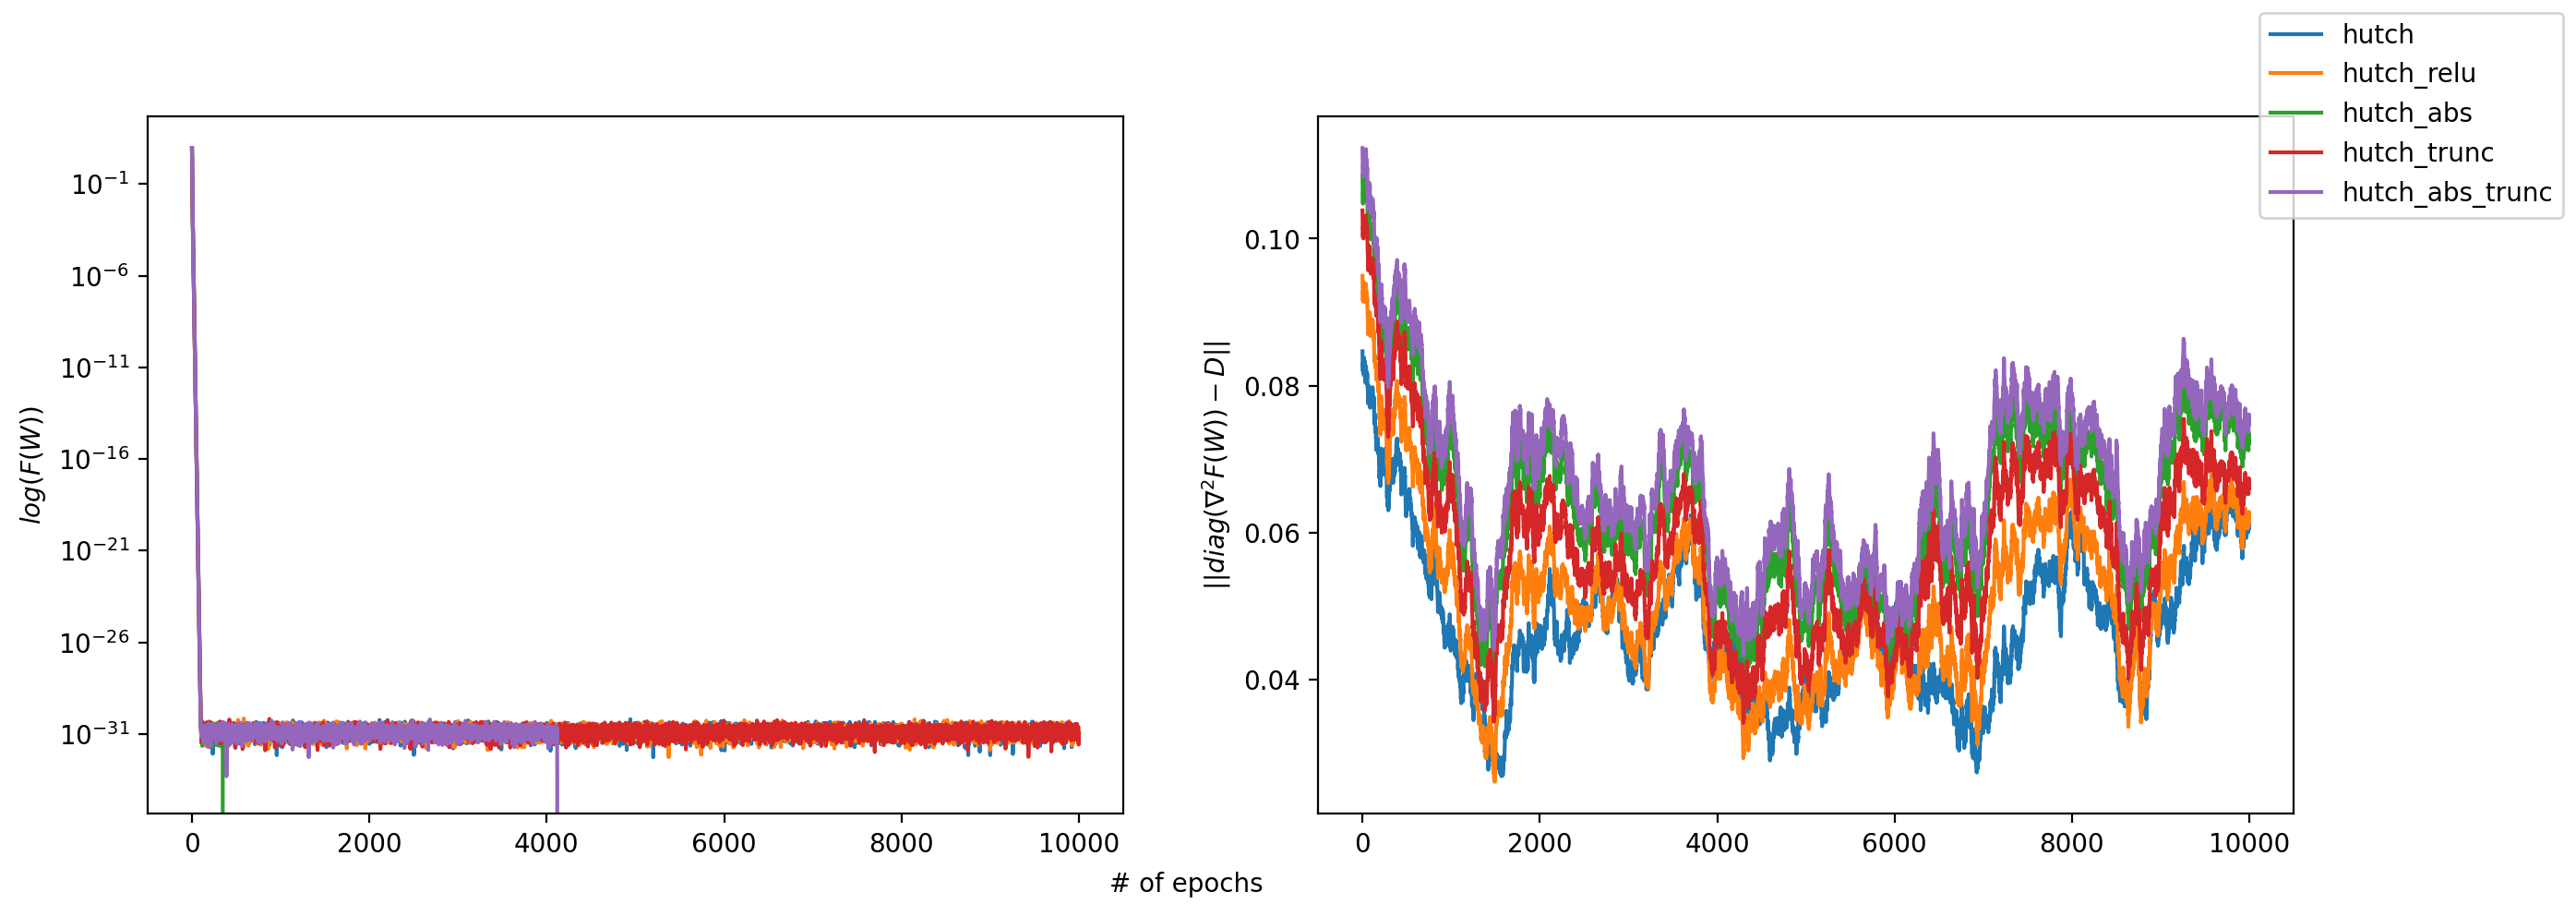

In [246]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=200)

ax1_trunc = -1
ax2_trunc = -1

ax1.semilogy([x[0] for x in hist_hutch[:ax1_trunc]])
ax1.semilogy([x[0] for x in hist_hutch_relu[:ax1_trunc]])
ax1.semilogy([x[0] for x in hist_hutch_abs[:ax1_trunc]])
ax1.semilogy([x[0] for x in hist_hutch_trunc[:ax1_trunc]])
ax1.semilogy([x[0] for x in hist_hutch_abs_trunc[:ax1_trunc]])

ax2.plot(diff_hutch[:ax2_trunc])
ax2.plot(diff_hutch_relu[:ax2_trunc])
ax2.plot(diff_hutch_abs[:ax2_trunc])
ax2.plot(diff_hutch_trunc[:ax2_trunc])
ax2.plot(diff_hutch_abs_trunc[:ax2_trunc])

ax1.set_ylabel(r"$ log(F(W)) $")
ax2.set_ylabel(r"$\|\| diag(\nabla^2 F(W)) - D  \|\|$")

fig.text(0.5, 0.04, '# of epochs', ha='center')

# ax2.set_ylim(0, 2)

fig.legend(["hutch", "hutch_relu", "hutch_abs", "hutch_trunc", "hutch_abs_trunc"])

fig.savefig("different_hutch_init_badly_scaled.svg", format="svg")

In [200]:
f, grad, hess = mse, grad_mse, hess_mse
# f, grad, hess = logreg, grad_logreg, hess_logreg

# SGD

In [201]:
def sgd(train_data, train_target, lr):

    train_load = torch.utils.data.TensorDataset(train_data, train_target)
    train_dataloader = torch.utils.data.DataLoader(train_load, batch_size=batch_size, shuffle=True)   

    w = torch.zeros(train_data.shape[1]).requires_grad_()

    loss = f(w, train_data, train_target)
    g = grad(w, train_data, train_target)

    diff = torch.norm(w.detach().cpu() - xopt)

    print(f"||x - xopt||: {diff.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")


    hist = [[diff.item(), (torch.linalg.norm(g) ** 2).item()]]

    for step in range(EPOCHS):
        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            loss = f(w, batch_data, batch_target)
            g = grad(w, batch_data, batch_target)
            grad_norm_sq = torch.linalg.norm(g) ** 2

            with torch.no_grad():
                w.sub_(lr * g)

        loss = f(w, train_data, train_target)
        g = grad(w, train_data, train_target)
        diff = torch.norm(w.detach().cpu() - xopt)

        print(f"||x - xopt||: {diff} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")

        hist.append([diff.item(), (torch.linalg.norm(g) ** 2 ).item()])

    return hist

In [202]:
hist_sgd = sgd(train_data, train_target, 0.005)

||x - xopt||: 5.742156689518558 | GradNorm^2: 427744.73952263943
||x - xopt||: 2.8370224091881715 | GradNorm^2: 63520.826507957645
||x - xopt||: 1.6962137456849822 | GradNorm^2: 16294.56931208942
||x - xopt||: 1.1134285744025363 | GradNorm^2: 5419.010771922795
||x - xopt||: 0.7773077415895843 | GradNorm^2: 2098.300846129053
||x - xopt||: 0.5679720770554315 | GradNorm^2: 909.4712514559816
||x - xopt||: 0.4293840429247404 | GradNorm^2: 432.99863605869086
||x - xopt||: 0.3327912033748079 | GradNorm^2: 223.2417695778549
||x - xopt||: 0.2625640154306789 | GradNorm^2: 122.95571473097472
||x - xopt||: 0.20977915688271573 | GradNorm^2: 71.40545326702426
||x - xopt||: 0.16909006934683188 | GradNorm^2: 43.21000566687327
||x - xopt||: 0.13713476218429269 | GradNorm^2: 26.973317880193996
||x - xopt||: 0.11169746581873519 | GradNorm^2: 17.22869266339713
||x - xopt||: 0.09125237212894684 | GradNorm^2: 11.189450366367877
||x - xopt||: 0.07470694768899336 | GradNorm^2: 7.354630826173801
||x - xopt||: 

# SPS

In [203]:
def sps(train_data, train_target):
    train_load = torch.utils.data.TensorDataset(train_data, train_target)
    train_dataloader = torch.utils.data.DataLoader(train_load, batch_size=batch_size, shuffle=True)

    w = torch.zeros(train_data.shape[1]).requires_grad_()

    loss = f(w, train_data, train_target)
    g = grad(w, train_data, train_target)
    diff = torch.norm(w.detach().cpu() - xopt)

    hist = [[diff.item(), (torch.linalg.norm(g) ** 2).item()]]

    for step in range(EPOCHS):
        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            loss = f(w, batch_data, batch_target)
            g = grad(w, batch_data, batch_target)
            grad_norm_sq = torch.linalg.norm(g) ** 2
            ps = loss / grad_norm_sq

            with torch.no_grad():
                w.sub_(ps * g)

        loss = f(w, train_data, train_target)
        g = grad(w, train_data, train_target)
        diff = torch.norm(w.detach().cpu() - xopt)

        print(f"||x - xopt||: {diff} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")

        hist.append([diff.item(), (torch.linalg.norm(g) ** 2 ).item()])

    return hist

In [204]:
hist_sps = sps(train_data, train_target)

||x - xopt||: 3.27553266083247 | GradNorm^2: 97651.23313389727
||x - xopt||: 1.8915997588472286 | GradNorm^2: 22168.619190727553
||x - xopt||: 1.09054451741649 | GradNorm^2: 5058.990681464691
||x - xopt||: 0.6315343672188626 | GradNorm^2: 1141.360815738354
||x - xopt||: 0.365484181664882 | GradNorm^2: 256.09751943484724
||x - xopt||: 0.2037658215412072 | GradNorm^2: 59.536624279776376
||x - xopt||: 0.10660061142834239 | GradNorm^2: 14.576139108009087
||x - xopt||: 0.05373381163542148 | GradNorm^2: 3.634636359979176
||x - xopt||: 0.026929724197669088 | GradNorm^2: 0.913609989707331
||x - xopt||: 0.013552750240797547 | GradNorm^2: 0.24481657434297233
||x - xopt||: 0.0071995645576692505 | GradNorm^2: 0.10525554977200123
||x - xopt||: 0.004813237038400224 | GradNorm^2: 0.06121660195090957
||x - xopt||: 0.0034584029111779167 | GradNorm^2: 0.024997418501800348
||x - xopt||: 0.0023363598471907734 | GradNorm^2: 0.01424483056762935
||x - xopt||: 0.0016747157832000476 | GradNorm^2: 0.00594966453

In [205]:
def sps_max(train_data, train_target, lr_bound):

    train_load = torch.utils.data.TensorDataset(train_data, train_target)
    train_dataloader = torch.utils.data.DataLoader(train_load, batch_size=batch_size, shuffle=True)

    w = torch.zeros(train_data.shape[1]).requires_grad_()

    loss = f(w, train_data, train_target)
    g = grad(w, train_data, train_target)
    diff = torch.norm(w.detach().cpu() - xopt)

    hist = [[diff.item(), (torch.linalg.norm(g) ** 2).item()]]

    for step in range(EPOCHS):
        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            loss = f(w, batch_data, batch_target)
            g = grad(w, batch_data, batch_target)
            grad_norm_sq = torch.linalg.norm(g) ** 2
            ps = torch.minimum(loss / grad_norm_sq, torch.tensor(lr_bound))

            with torch.no_grad():
                w.sub_(ps * g)

        loss = f(w, train_data, train_target)
        g = grad(w, train_data, train_target)
        diff = torch.norm(w.detach().cpu() - xopt)

        print(f"||x - xopt||: {diff} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")

        hist.append([diff.item(), (torch.linalg.norm(g) ** 2 ).item()])

    return hist

    

In [206]:
hist_sps_max = sps_max(train_data, train_target, 0.01)

||x - xopt||: 3.27553266083247 | GradNorm^2: 97651.2331338973
||x - xopt||: 1.8915997588472286 | GradNorm^2: 22168.619190727553
||x - xopt||: 1.09054451741649 | GradNorm^2: 5058.990681464691
||x - xopt||: 0.6315343672188628 | GradNorm^2: 1141.3608157383555
||x - xopt||: 0.3654841816648822 | GradNorm^2: 256.09751943484736
||x - xopt||: 0.21692277942580385 | GradNorm^2: 69.72689407987744
||x - xopt||: 0.1360468936313161 | GradNorm^2: 24.740495651466468
||x - xopt||: 0.08692077796579718 | GradNorm^2: 9.714320078218023
||x - xopt||: 0.055904549882880857 | GradNorm^2: 3.9586030921243487
||x - xopt||: 0.036050434083281235 | GradNorm^2: 1.6356547640309018
||x - xopt||: 0.023274827107369684 | GradNorm^2: 0.6797097614740772
||x - xopt||: 0.015035775674610796 | GradNorm^2: 0.28324134508665394
||x - xopt||: 0.009716648145157096 | GradNorm^2: 0.11823093382428503
||x - xopt||: 0.006280625220478033 | GradNorm^2: 0.049429500689354484
||x - xopt||: 0.004060307588473768 | GradNorm^2: 0.0207131079817610

# Diagonal of True Hessian
$B_t = diag(\nabla^2 F(w))$ 

$ w_{t+1} = \mathop{{\arg \min}}\limits_{w \in \mathbb{R}^d} \  \tfrac{1}{2} \|w - w_t\|_{B_t}^2  \quad \text{s.t.} \quad 
  f_i(w_t) + \langle \nabla f_i(w_t), w-w_t\rangle = 0 $

is given by

$w_{t+1} = w_t - \tfrac{f_i(w_t)}{{||\nabla f_i(w_t)||}_{B_t^{-1}}^2} B_t^{-1} \nabla f_i(w_t).$

In [207]:
def psps_hessdiag(train_data, train_target):

    train_load = torch.utils.data.TensorDataset(train_data, train_target)
    train_dataloader = torch.utils.data.DataLoader(train_load, batch_size=batch_size, shuffle=True)

    w = torch.zeros(train_data.shape[1]).requires_grad_()
    hist = []

    loss = f(w, train_data, train_target)
    g = grad(w, train_data, train_target)
    hessian = hess(w, train_data, train_target)

    diff = torch.norm(w.detach().cpu() - xopt)

    grad_norm_sq = torch.dot(g, g)

    print(f"||x - xopt||: {diff} | GradNorm^2: {grad_norm_sq.item()}")
    hist.append([diff.item(), grad_norm_sq.item()])



    for step in range(EPOCHS):
        
        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            loss = f(w, batch_data, batch_target)
            g = grad(w, batch_data, batch_target)
            hessian = hess(w, train_data, train_target)
            hessdiag_inv = 1 / torch.diagonal(hessian)
            precond = hessdiag_inv

            weighted_grad_norm_sq = torch.dot(g, precond * g)

            ps = loss / weighted_grad_norm_sq
            
            with torch.no_grad():
                w.sub_(ps * precond * g)

        loss = f(w, train_data, train_target)
        g = grad(w, train_data, train_target)
        grad_norm_sq = torch.dot(g, g)
        diff = torch.norm(w.detach().cpu() - xopt)

        print(f"||x - xopt||: {diff} | GradNorm^2: {grad_norm_sq.item()}")
        hist.append([diff.item(), grad_norm_sq.item()])

    return hist


In [208]:
hist_psps_diaghess = psps_hessdiag(train_data, train_target)

||x - xopt||: 5.742156689518558 | GradNorm^2: 427744.7395226394
||x - xopt||: 3.1574503353149885 | GradNorm^2: 99973.42519904432
||x - xopt||: 1.782946255021286 | GradNorm^2: 22852.915574809063
||x - xopt||: 1.0368925348003135 | GradNorm^2: 5136.105068292436
||x - xopt||: 0.6139959387000362 | GradNorm^2: 1158.9787781104337
||x - xopt||: 0.36048705475442744 | GradNorm^2: 263.87632250426606
||x - xopt||: 0.20276094907535605 | GradNorm^2: 60.984598586660766
||x - xopt||: 0.10664834592557192 | GradNorm^2: 14.947699836359925
||x - xopt||: 0.053869655632437584 | GradNorm^2: 3.7280645904626954
||x - xopt||: 0.027004082633949357 | GradNorm^2: 0.9574522473558169
||x - xopt||: 0.013708008824805776 | GradNorm^2: 0.2531791571475089
||x - xopt||: 0.007238027926235523 | GradNorm^2: 0.09713482593748721
||x - xopt||: 0.0045545253475823815 | GradNorm^2: 0.046208582504093196
||x - xopt||: 0.0030847625611448173 | GradNorm^2: 0.019598554786932093
||x - xopt||: 0.0020419849945335004 | GradNorm^2: 0.0090877

# PSPS

In [209]:
def psps_hutch(train_data, train_target, init_iters, step_iters):

    train_load = torch.utils.data.TensorDataset(train_data, train_target)
    train_dataloader = torch.utils.data.DataLoader(train_load, batch_size=batch_size, shuffle=True)

    w = torch.zeros(train_data.shape[1]).requires_grad_()
    hist = []

    loss = f(w, train_data, train_target)
    g = grad(w, train_data, train_target)
    hessian = hess(w, train_data, train_target)
    hessian_inv = torch.inverse(hessian)


    alpha=0.1
    beta=0.999

    Dk = diag_estimate_old(w, g, init_iters)
    vk = diag_estimate_old(w, g, step_iters)

    # Smoothing and Truncation 
    Dk = beta * Dk + (1 - beta) * vk
    Dk_hat = torch.abs(Dk)
    Dk_hat[Dk_hat < alpha] = alpha
    Dk_hat_inv = 1 / Dk_hat


    grad_norm_sq = torch.dot(g, g)

    print(f"Loss: {loss.item()} | GradNorm^2: {grad_norm_sq.item()}")
    hist.append([loss.item(), grad_norm_sq.item()])

    precond_diff = [torch.norm(Dk_hat_inv - torch.diagonal(hessian_inv)).item()]

    for step in range(EPOCHS):
        
        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            loss = f(w, batch_data, batch_target)
            g = grad(w, batch_data, batch_target)

            vk = diag_estimate_old(w, g, step_iters)

            # Smoothing and Truncation 
            Dk = beta * Dk + (1 - beta) * vk
            Dk_hat = torch.abs(Dk)
            Dk_hat[Dk_hat < alpha] = alpha
            Dk_hat_inv = 1 / Dk_hat

            weighted_grad_norm_sq = torch.dot(g, Dk_hat_inv * g)

            ps = loss / weighted_grad_norm_sq
            
            with torch.no_grad():
                w.sub_(ps * Dk_hat_inv * g)

        loss = f(w, train_data, train_target)
        g = grad(w, train_data, train_target)
        grad_norm_sq = torch.dot(g, g)

        print(f"Loss: {loss.item()} | GradNorm^2: {grad_norm_sq.item()}")
        hist.append([loss.item(), grad_norm_sq.item()])


        precond_diff.append(torch.norm(Dk_hat_inv - torch.diagonal(hessian_inv)).item())

    return hist, precond_diff

# Newton's Method

In [210]:
def nm(train_data, train_target):

    train_load = torch.utils.data.TensorDataset(train_data, train_target)
    train_dataloader = torch.utils.data.DataLoader(train_load, batch_size=batch_size, shuffle=True)
        
    w = torch.zeros(train_data.shape[1]).requires_grad_()

    loss = f(w, train_data, train_target)
    g = grad(w, train_data, train_target)

    diff = torch.norm(w.detach().cpu() - xopt)

    hist = [[diff.item(), (torch.linalg.norm(g) ** 2).item()]]

    for step in range(EPOCHS):
        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            loss = f(w, batch_data, batch_target)
            g = grad(w, batch_data, batch_target)
            hessian = hess(w, batch_data, batch_target)
            hessian_inv = torch.inverse(hessian)

            with torch.no_grad():
                w.sub_(hessian_inv @ g)

        loss = f(w, train_data, train_target)
        g = grad(w, train_data, train_target)
        diff = torch.norm(w.detach().cpu() - xopt)

        print(f"|| x - xopt ||: {diff} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")

        hist.append([diff.item(), (torch.linalg.norm(g) ** 2 ).item()])

    return hist

# PSPS Preconditioned by $V^{-1}V^{-1}$

In [211]:
def psps_vv(train_data, train_target, scaling_vec=None):

    train_load = torch.utils.data.TensorDataset(train_data, train_target)
    train_dataloader = torch.utils.data.DataLoader(train_load, batch_size=batch_size, shuffle=True)

    w = torch.zeros(train_data.shape[1]).requires_grad_()
    hist = []

    loss = f(w, train_data, train_target)
    g = grad(w, train_data, train_target)
    hessian = hess(w, train_data, train_target)

    diff = torch.norm(w.detach().cpu() - xopt)

    grad_norm_sq = torch.dot(g, g)

    print(f"||x - xopt||: {diff} | GradNorm^2: {grad_norm_sq.item()}")
    hist.append([diff.item(), grad_norm_sq.item()])

    if scaling_vec == None:
        scaling_vec = torch.ones(train_data.shape[1])

    precond = (1 / scaling_vec) * (1 / scaling_vec)

    for step in range(EPOCHS):
        
        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            loss = f(w, batch_data, batch_target)
            g = grad(w, batch_data, batch_target)
            
            weighted_grad_norm_sq = torch.dot(g, precond * g)

            ps = loss / weighted_grad_norm_sq
            
            with torch.no_grad():
                w.sub_(ps * precond * g)

        loss = f(w, train_data, train_target)
        g = grad(w, train_data, train_target)
        grad_norm_sq = torch.dot(g, g)
        diff = torch.norm(w.detach().cpu() - xopt)

        print(f"||x - xopt||: {diff} | GradNorm^2: {grad_norm_sq.item()}")
        hist.append([diff.item(), grad_norm_sq.item()])

    return hist


In [212]:
hist_psps_vv = psps_vv(train_data, train_target)

||x - xopt||: 5.742156689518558 | GradNorm^2: 427744.7395226394
||x - xopt||: 3.2755326608324697 | GradNorm^2: 97651.2331338973
||x - xopt||: 1.8915997588472284 | GradNorm^2: 22168.61919072755
||x - xopt||: 1.0905445174164898 | GradNorm^2: 5058.990681464687
||x - xopt||: 0.6315343672188627 | GradNorm^2: 1141.3608157383546
||x - xopt||: 0.3654841816648821 | GradNorm^2: 256.0975194348472
||x - xopt||: 0.20376582154120731 | GradNorm^2: 59.536624279776404
||x - xopt||: 0.10660061142834236 | GradNorm^2: 14.576139108009096
||x - xopt||: 0.053733811635421506 | GradNorm^2: 3.634636359979179
||x - xopt||: 0.02692972419766928 | GradNorm^2: 0.9136099897073797
||x - xopt||: 0.013552750240798227 | GradNorm^2: 0.2448165743431108
||x - xopt||: 0.007199564557672689 | GradNorm^2: 0.10525554977233897
||x - xopt||: 0.004813237038406442 | GradNorm^2: 0.06121660195095772
||x - xopt||: 0.003458402911181078 | GradNorm^2: 0.024997418501898065
||x - xopt||: 0.0023363598471944596 | GradNorm^2: 0.014244830567654

In [213]:
hist_psps_vv_scaled = psps_vv(train_data_scaled, train_target_scaled, scaling_vec)

RuntimeError: The size of tensor a (100) must match the size of tensor b (20) at non-singleton dimension 0

In [ ]:
hist_sgd_scaled = sgd(train_data_scaled, train_target_scaled, 1e-7)

||x - xopt||: 9.762544884917334 | GradNorm^2: 3886616823.0127435
||x - xopt||: 9.760637084979384 | GradNorm^2: 2580300834.0482883
||x - xopt||: 9.7590021685729 | GradNorm^2: 1763159241.073688
||x - xopt||: 9.757584789697566 | GradNorm^2: 1242241038.7735686
||x - xopt||: 9.75634218203371 | GradNorm^2: 903083740.6953895
||x - xopt||: 9.755241110529154 | GradNorm^2: 677158777.2264632
||x - xopt||: 9.754255600429222 | GradNorm^2: 522992753.4556278
||x - xopt||: 9.753365234681104 | GradNorm^2: 415169657.0402969
||x - xopt||: 9.75255387047831 | GradNorm^2: 337889504.067008
||x - xopt||: 9.751808667131876 | GradNorm^2: 281171529.0980466
||x - xopt||: 9.751119346585735 | GradNorm^2: 238599284.4691845
||x - xopt||: 9.750477628666385 | GradNorm^2: 205969614.2727568
||x - xopt||: 9.749876798146808 | GradNorm^2: 180474861.4215205
||x - xopt||: 9.749311371629902 | GradNorm^2: 160202005.4866408
||x - xopt||: 9.748776840285387 | GradNorm^2: 143821815.29036388
||x - xopt||: 9.748269470415014 | GradNor

In [ ]:
hist_sps_scaled = sps(train_data_scaled, train_target_scaled)

||x - xopt||: 9.74229695436901 | GradNorm^2: 6036508752.312372
||x - xopt||: 9.749025421588986 | GradNorm^2: 2767159052.839676
||x - xopt||: 9.735025454233494 | GradNorm^2: 11154017905.105654
||x - xopt||: 9.74119771115001 | GradNorm^2: 203798030.71802226
||x - xopt||: 9.68482422181026 | GradNorm^2: 177955418317.18146
||x - xopt||: 9.697450071033625 | GradNorm^2: 38395513176.45945
||x - xopt||: 9.705255808040262 | GradNorm^2: 4384260076.554631
||x - xopt||: 9.713759004498748 | GradNorm^2: 3758543488.3794217
||x - xopt||: 9.7070638024348 | GradNorm^2: 4879148291.915782
||x - xopt||: 9.714686437109567 | GradNorm^2: 2776447227.0017595
||x - xopt||: 9.706438961455314 | GradNorm^2: 7926607377.784812
||x - xopt||: 9.713232375059794 | GradNorm^2: 567008603.4542311
||x - xopt||: 9.696751054158517 | GradNorm^2: 57690270047.64331
||x - xopt||: 9.705206581917313 | GradNorm^2: 9083901931.783846
||x - xopt||: 9.711631063863399 | GradNorm^2: 230132187.89894044
||x - xopt||: 9.680729593088039 | GradN

In [ ]:
hist_sps_max_scaled = sps_max(train_data_scaled, train_target_scaled, 0.01)

||x - xopt||: 9.74229695436901 | GradNorm^2: 6036508752.312372
||x - xopt||: 9.749025421588986 | GradNorm^2: 2767159052.8396783
||x - xopt||: 9.735025454233494 | GradNorm^2: 11154017905.105648
||x - xopt||: 9.74119771115001 | GradNorm^2: 203798030.71802303
||x - xopt||: 9.684824221810262 | GradNorm^2: 177955418317.18094
||x - xopt||: 9.697450071033625 | GradNorm^2: 38395513176.45928
||x - xopt||: 9.705255808040262 | GradNorm^2: 4384260076.554601
||x - xopt||: 9.713759004498748 | GradNorm^2: 3758543488.379466
||x - xopt||: 9.7070638024348 | GradNorm^2: 4879148291.915678
||x - xopt||: 9.714686437109567 | GradNorm^2: 2776447227.001897
||x - xopt||: 9.706438961455314 | GradNorm^2: 7926607377.784188
||x - xopt||: 9.713232375059796 | GradNorm^2: 567008603.4544419
||x - xopt||: 9.696751054158517 | GradNorm^2: 57690270047.62006
||x - xopt||: 9.705206581917317 | GradNorm^2: 9083901931.77828
||x - xopt||: 9.711631063863402 | GradNorm^2: 230132187.8999431
||x - xopt||: 9.68072959308812 | GradNorm

In [ ]:
hist_psps_diaghess_scaled = psps_hessdiag(train_data_scaled, train_target_scaled)

||x - xopt||: 9.762544884917334 | GradNorm^2: 3886616823.012745
||x - xopt||: 88.24521210122244 | GradNorm^2: 745714238.7659274
||x - xopt||: 125.55634432924306 | GradNorm^2: 60210048.58764717
||x - xopt||: 167.2425925375947 | GradNorm^2: 19088760.422998846
||x - xopt||: 209.606000612085 | GradNorm^2: 88910750.21534967
||x - xopt||: 209.85431406816778 | GradNorm^2: 6749047.957026193
||x - xopt||: 250.27640874067455 | GradNorm^2: 101776115.44399199
||x - xopt||: 247.9596614098983 | GradNorm^2: 5923942.865156205
||x - xopt||: 261.95890255800566 | GradNorm^2: 71214774.3699561
||x - xopt||: 264.54756046829937 | GradNorm^2: 5107454.055623922
||x - xopt||: 273.4072655694777 | GradNorm^2: 36531810.94165405
||x - xopt||: 272.3414579558688 | GradNorm^2: 1238183.8692350697
||x - xopt||: 290.96882884269985 | GradNorm^2: 48211469.800212845
||x - xopt||: 291.0212358598574 | GradNorm^2: 5831593.231818841
||x - xopt||: 290.79527860065554 | GradNorm^2: 3353770.708778672
||x - xopt||: 291.9616166332054

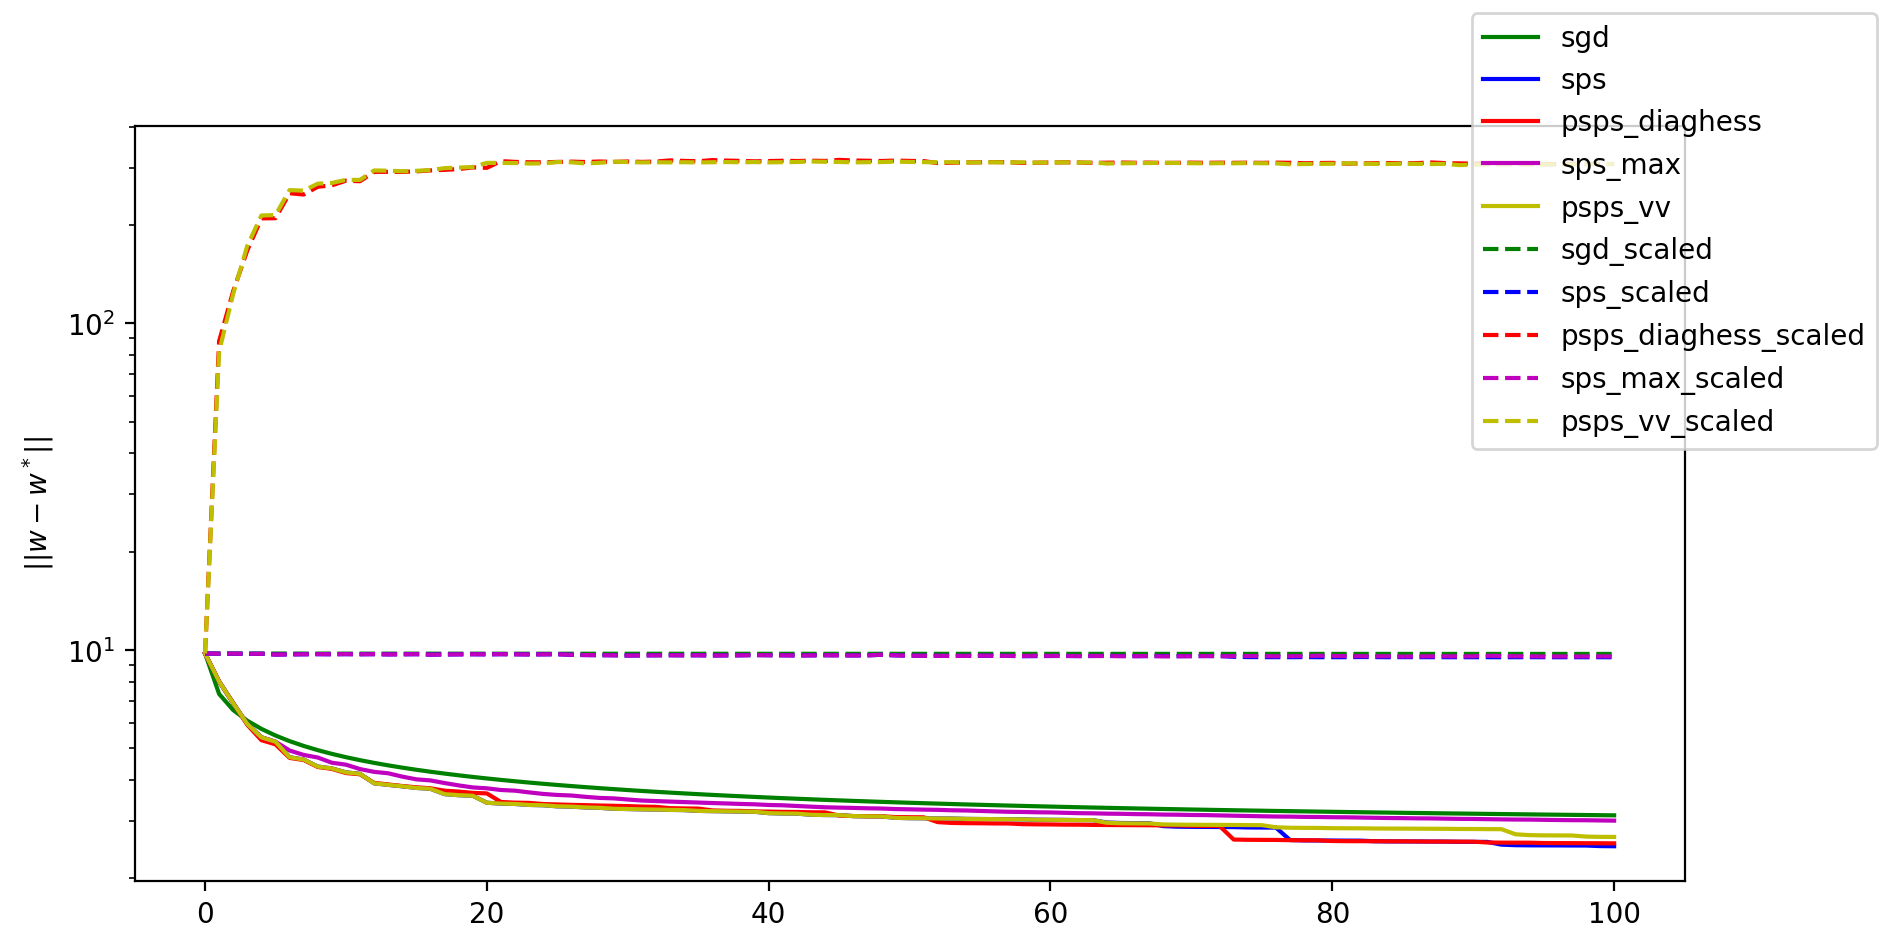

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=200)

fig = plt.figure(figsize=(10, 5), dpi=200)

plt.semilogy([x[0] for x in hist_sgd], 'g', label="sgd")
plt.semilogy([x[0] for x in hist_sps], 'b', label="sps")
plt.semilogy([x[0] for x in hist_psps_diaghess], 'r', label="psps_diaghess")
plt.semilogy([x[0] for x in hist_sps_max], 'm', label="sps_max")
plt.semilogy([x[0] for x in hist_psps_vv], 'y', label="psps_vv")



plt.semilogy([x[0] for x in hist_sgd_scaled], 'g--', label="sgd_scaled")
plt.semilogy([x[0] for x in hist_sps_scaled], 'b--', label="sps_scaled")
plt.semilogy([x[0] for x in hist_psps_diaghess_scaled], 'r--', label="psps_diaghess_scaled")
plt.semilogy([x[0] for x in hist_sps_max_scaled], 'm--', label="sps_max_scaled")
plt.semilogy([x[0] for x in hist_psps_vv_scaled], 'y--', label="psps_vv_scaled")

plt.ylabel(r"$\|\| w - w^* \|\|$")

fig.legend()

plt.savefig("temptemp.jpeg")

In [ ]:
def test_hutch(train_data, train_target, lr, init_iters, step_iters):

    train_load = torch.utils.data.TensorDataset(train_data, train_target)
    train_dataloader = torch.utils.data.DataLoader(train_load, batch_size=batch_size, shuffle=True)

    def diag_estimate_test(weights, grad, iters):
        # Ds = []
        Ds = torch.zeros_like(weights)
        for j in range(iters):
            z = rademacher_old(weights)
            # with torch.no_grad():
            #     hvp = torch.matmul(hessian, z)
            with torch.no_grad():
                hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
            Ds.add_(hvp*z)
            # Ds.append((hvp*z))

        return Ds.div(iters)

        # return torch.mean(torch.stack(Ds), 0)
        
    w = torch.zeros(train_data.shape[1]).requires_grad_()

    loss = f(w, train_data, train_target)
    g = grad(w, train_data, train_target)

    diff = torch.norm(w.detach().cpu() - xopt)

    hist = [[diff.item(), (torch.linalg.norm(g) ** 2).item()]]

    hessian = hess(w, train_data, train_target)
    hessian_inv_diag = 1 / torch.inverse(hessian)


    alpha=0.1
    beta=0.9

    Dk = diag_estimate_test(w, g, init_iters)
    vk = diag_estimate_test(w, g, step_iters)

    # Smoothing and Truncation 
    Dk = beta * Dk + (1 - beta) * vk
    Dk_hat = torch.abs(Dk)
    Dk_hat[Dk_hat < alpha] = alpha
    Dk_hat_inv = 1 / Dk_hat

    print(torch.norm(hessian_inv_diag - Dk_hat_inv))

    for step in range(EPOCHS):
        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            loss = f(w, batch_data, batch_target)
            g = grad(w, batch_data, batch_target)
            
            vk = diag_estimate_test(w, g, step_iters)
            
            # Smoothing and Truncation 
            Dk = beta * Dk + (1 - beta) * vk
            Dk_hat = torch.abs(Dk)
            Dk_hat[Dk_hat < alpha] = alpha
            Dk_hat_inv = 1 / Dk_hat

            with torch.no_grad():
                w.sub_(lr * g)

        loss = f(w, train_data, train_target)
        g = grad(w, train_data, train_target)
        diff = torch.norm(w.detach().cpu() - xopt)

        hutch_diff = torch.norm(hessian_inv_diag - Dk_hat_inv)

        print(f"norm(x - xopt): {diff} | norm(diag(Hessian) - Hutch): {hutch_diff}")

        hist.append([diff.item(), hutch_diff])

    return hist

In [ ]:
hist_hutch = test_hutch(train_data, train_target, 0.001, 1000, 1)

tensor(450.3053)
norm(x - xopt): 8.962436454409874 | norm(diag(Hessian) - Hutch): 450.3052135049233
norm(x - xopt): 8.393448182684534 | norm(diag(Hessian) - Hutch): 450.3062326592635
norm(x - xopt): 7.970436506401922 | norm(diag(Hessian) - Hutch): 450.3049270069397
norm(x - xopt): 7.642786345802189 | norm(diag(Hessian) - Hutch): 450.30446916497755
norm(x - xopt): 7.379791249180674 | norm(diag(Hessian) - Hutch): 450.30424514521474
norm(x - xopt): 7.162277772574966 | norm(diag(Hessian) - Hutch): 450.3041841975644
norm(x - xopt): 6.977876954999153 | norm(diag(Hessian) - Hutch): 450.3044105305065
norm(x - xopt): 6.81834168774757 | norm(diag(Hessian) - Hutch): 450.3043231336817
norm(x - xopt): 6.677997762989474 | norm(diag(Hessian) - Hutch): 450.3054433273424
norm(x - xopt): 6.552826977510604 | norm(diag(Hessian) - Hutch): 450.30357280968076
norm(x - xopt): 6.43990884139607 | norm(diag(Hessian) - Hutch): 450.3054850907403
norm(x - xopt): 6.3370706650558875 | norm(diag(Hessian) - Hutch): 450

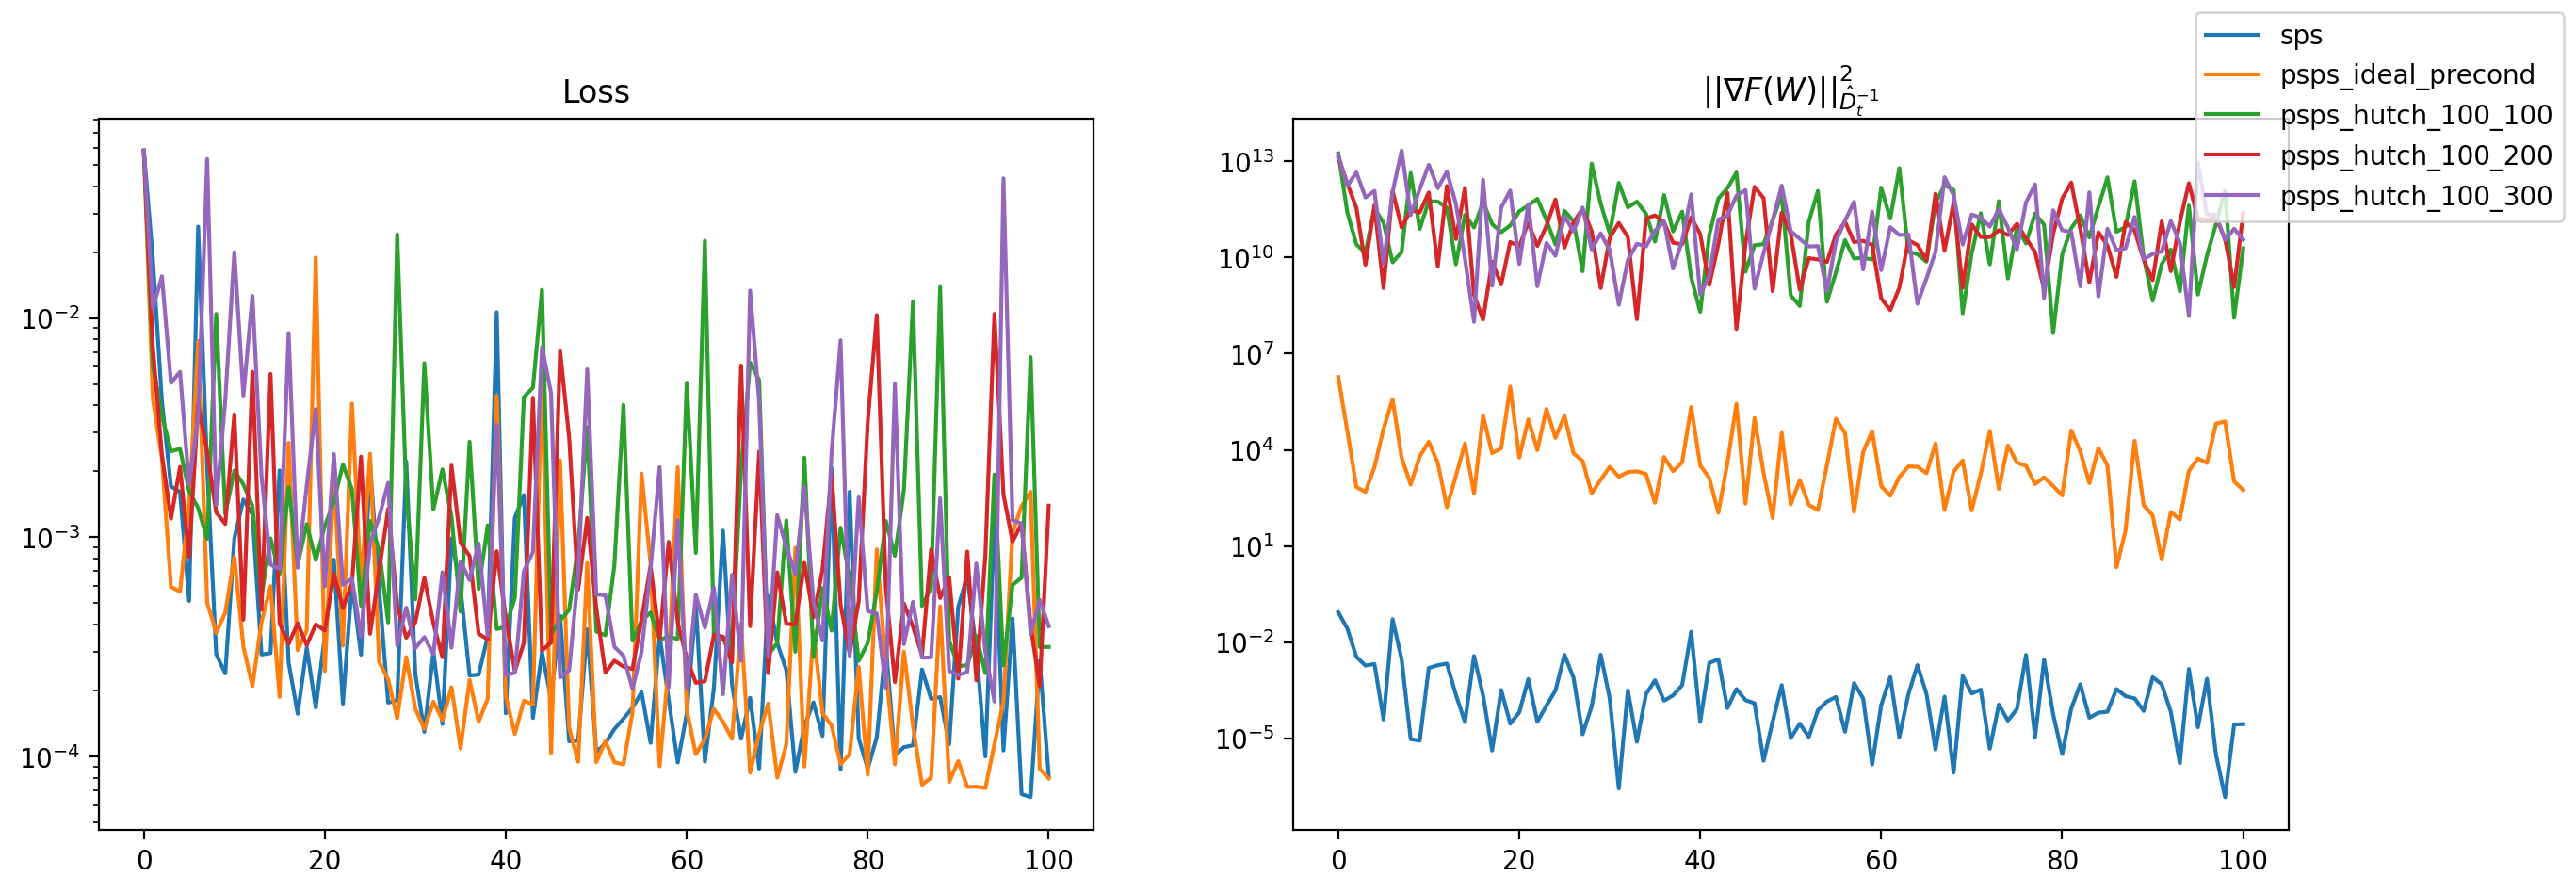

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=200)
ax1.semilogy([x[0] for x in hist_sps])
ax1.semilogy([x[0] for x in hist_psps_ideal])
ax1.semilogy([x[0] for x in hist_psps_hutch_100_100])
ax1.semilogy([x[0] for x in hist_psps_hutch_100_200])
ax1.semilogy([x[0] for x in hist_psps_hutch_100_300])
ax1.set_title("Loss")

ax2.semilogy([x[1] for x in hist_sps])
ax2.semilogy([x[1] for x in hist_psps_ideal])
ax2.semilogy([x[1] for x in hist_psps_hutch_100_100])
ax2.semilogy([x[1] for x in hist_psps_hutch_100_200])
ax2.semilogy([x[1] for x in hist_psps_hutch_100_300])

ax2.set_title(r"$\|\| \nabla F(W) \|\|^2_{\hat{D}^{-1}_t}$")

fig.legend(["sps", "psps_ideal_precond", "psps_hutch_100_100", "psps_hutch_100_200", "psps_hutch_100_300"])

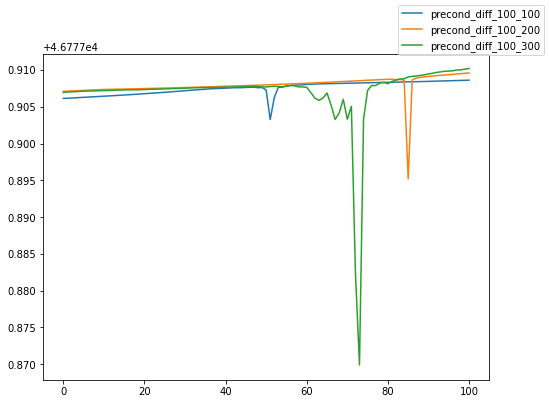

In [ ]:
fig = plt.figure(figsize=(8, 6))

plt.plot(precond_diff_100_100)
plt.plot(precond_diff_100_200)
plt.plot(precond_diff_100_300)

fig.legend(["precond_diff_100_100", "precond_diff_100_200", "precond_diff_100_300"])
